<div style="border:solid Chocolate 2px; padding: 40px">

# Прогноз СТМ-продаж Ленты

</div>

Цель: разработать модель для прогноза спроса на 14 дней на товары собственного производства. Метрикой качества выступает WAPE, посчитанный на уровне товар, магазин, день.

Заказчику важны:

- качество предсказания;
- эффективность и масштабируемость;
- интерпретируемость.

## План работы
1. Обзор данных.

- Рассмотрим датасеты, которые имеются в нашем распоряжении - из каких данных они состоят.

2. Подготовка данных.

- Объединим таблицы.
- Изучим полученный датасет, проведем предобработку.
- Скорректируем типы данных, чтобы можно было их использовать для дальнейшего анализа.

3. Исследовательский анализ данных.

- Изучим взаимоотношение признаков в зависимости от магазинов, групп продуктов и т.д.
- Посмотрим на корреляции признаков.
- Сделаем анализ временных рядов.

4. Разделение на группы
- Посмотрим, как коррелируют между собой группы товаров и магазины.
- На основании анализа разделим датасет на группы, по которым будем обучать модели.

5. Подбор и обучение моделей.

- Проведем подготовку выборок
- Создадим дополнительные признаки
- Обучим Prophet и создадим future признаки для лучшего предсказания
- Построим Pipeline моделей для выделенных групп.
- Выберем наилучшую модель для каждой из групп (с лучшим показателем  WAPE)

6. Тестирование модели.

- Проверим работу выбранных моделей на тестовых данных.
- Оформим файл submission.

In [ ]:
pip install lightgbm -q

In [ ]:
pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 9.0 MB/s eta 0:00:0000:0100:01


In [ ]:
pip install prophet -q

In [ ]:
pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

In [ ]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans


from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import phik
from phik.report import correlation_report, plot_correlation_matrix
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.tsa.seasonal import seasonal_decompose

# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def load_data(path):
    pr_df = pd.read_csv(path + 'pr_df.csv')
    sales_df_train = pd.read_csv(path + 'sales_df_train.csv')
    sales_submission = pd.read_csv(path + 'sales_submission.csv')
    st_df = pd.read_csv(path + 'st_df.csv')
    return pr_df, sales_df_train, sales_submission, st_df

**ВНИМАНИЕ!!!** Для загрузки данных pr_df, sales_df_train, sales_submission, st_df и holidays, просим указать актуальное место хранения файлов.

In [ ]:
try:
    pr_df, sales_df_train, sales_submission, st_df = load_data('/Users/samolinovkonstantin/Desktop/IT/hackaton/sp_sales_task/')
except:
    try:
        pr_df, sales_df_train, sales_submission, st_df = load_data('C:/Users/Alexander/Desktop/sp_sales_task/')
    except:
        #pr_df, sales_df_train, sales_submission, st_df = load_data('')
        #pr_df, sales_df_train, sales_submission, st_df = load_data('/kaggle/input/lentahackathon/')
        pr_df, sales_df_train, sales_submission, st_df = load_data('/content/gdrive/MyDrive/Datasets/')
try:
    holidays = pd.read_csv('/content/gdrive/MyDrive/Datasets/holidays_covid_calendar_2.csv')
except:
    holidays = pd.read_csv('C:/Users/Alexander/Desktop/sp_sales_task/holidays_covid_calendar.csv')

In [ ]:
def dataframe_info(df):
    print("Размер:", df.shape)
    display(df.head())
    print("Info:\n")
    df.info()
    print()
    print("Основная статистика:\n", df.describe())
    print()
    print("Пропущенные значения:\n", df.isnull().sum())
    print()
    print("Дубликаты:\n", df.duplicated().sum())

# Предобработка и EDA

Для начала работы необходимо изучить данные, которые представленны в работу

## Анализ таблицы `sales_df_train`

sales_df_train.csv –данные по продажам за скользящий год для обучения.

Столбцы:
- st_id – захэшированное id магазина;
- pr_sku_id – захэшированное id товара;
- date – дата;
- pr_sales_type_id – флаг наличия промо;
- pr_sales_in_units – число проданных товаров всего (промо и без);
- pr_promo_sales_in_units – число проданных товаров с признаком промо;
- pr_sales_in_rub – продажи в РУБ всего (промо и без);
- pr_promo_sales_in_rub – продажи с признаком промо в РУБ;

In [ ]:
sales_df_train.sample(10)

st_id                         pr_sku_id  \
662833  42a0e188f5033bc65bf8d78622277c4e  a2f01e8907594a5cc33b21086a702036   
425389  16a5cdae362b8d27a1d8f8c7b78b4330  bf5f373eede102c71bf77874c78bdc59   
378439  fa7cdfad1a5aaf8370ebeda47a1ff1c3  dd58fb957a4cf683ad786792f9e8eec9   
48525   42a0e188f5033bc65bf8d78622277c4e  1b1f4205ab5d9b437c143fc6d7e18c80   
55979   fa7cdfad1a5aaf8370ebeda47a1ff1c3  e6fc24ca846339d204b0b50e9f772484   
254035  c81e728d9d4c2f636f067f89cc14862c  dfb085b0647b9ee8ce010670d1e30ab6   
405412  42a0e188f5033bc65bf8d78622277c4e  5bc0e44accee3ad26b2a39c3b2bf91fc   
700277  c81e728d9d4c2f636f067f89cc14862c  61952271208eea3eeaa506cde274a0ce   
353531  c81e728d9d4c2f636f067f89cc14862c  70f6f2543cdaf69fb2f89317e23a0929   
252289  c81e728d9d4c2f636f067f89cc14862c  f5cbf781243f069963c2de6d622a6b90   

              date  pr_sales_type_id  pr_sales_in_units  \
662833  2022-11-11                 0                0.0   
425389  2022-10-18                 1                1.0   
378439  2022-08-28                 1                4.0   
48525   2022-11-23                 0                2.0   
55979   2023-02-12                 0                0.0   
254035  2022-10-20                 1                2.0   
405412  2022-10-15                 0                2.0   
700277  2023-04-14                 0                1.0   
353531  2022-12-24                 0                3.0   
252289  2023-05-26                 1                1.0   

        pr_promo_sales_in_units  pr_sales_in_rub  pr_promo_sales_in_rub  
662833                      0.0             92.0                    0.0  
425389                      1.0            214.0                  214.0  
378439                      4.0            807.0                  807.0  
48525                       0.0            349.0                    0.0  
55979                       0.0             46.0                    0.0  
254035                      2.0             36.0                   36.0  
405412                      0.0             98.0                    0.0  
700277                      0.0            104.0                    0.0  
353531                      0.0            822.0                    0.0  
252289                      1.0            126.0                  126.0

In [ ]:
sales_df_train.isna().mean()*100

st_id                      0.0
pr_sku_id                  0.0
date                       0.0
pr_sales_type_id           0.0
pr_sales_in_units          0.0
pr_promo_sales_in_units    0.0
pr_sales_in_rub            0.0
pr_promo_sales_in_rub      0.0
dtype: float64

In [ ]:
sales_df_train.describe()

pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
count     883015.000000      883015.000000            883015.000000   
mean           0.406486           5.037956                 2.230010   
std            0.491178          13.402984                11.063288   
min            0.000000         -39.000000               -39.000000   
25%            0.000000           1.000000                 0.000000   
50%            0.000000           2.000000                 0.000000   
75%            1.000000           4.000000                 1.000000   
max            1.000000        2348.000000              2348.000000   

       pr_sales_in_rub  pr_promo_sales_in_rub  
count    883015.000000          883015.000000  
mean        596.705181             294.766561  
std        1577.366179            1402.764168  
min       -3373.000000           -3373.000000  
25%          98.000000               0.000000  
50%         224.000000               0.000000  
75%         540.000000             127.000000  
max      183265.000000          183265.000000

In [ ]:
len(sales_df_train.loc[sales_df_train['pr_promo_sales_in_rub'] < 0]), \
len(sales_df_train.loc[sales_df_train['pr_sales_in_rub'] < 0]), \
len(sales_df_train.loc[sales_df_train['pr_promo_sales_in_units'] < 0]), \
len(sales_df_train.loc[sales_df_train['pr_sales_in_units'] < 0])

(36, 78, 35, 71)

### Анализ st_id

In [ ]:
store_group = pd.DataFrame(sales_df_train.groupby('st_id')['st_id'].agg(count=('count')).sort_values('count', ascending=False)).reset_index()
store_group

st_id   count
0   c81e728d9d4c2f636f067f89cc14862c  174687
1   16a5cdae362b8d27a1d8f8c7b78b4330  157542
2   42a0e188f5033bc65bf8d78622277c4e  140286
3   f7e6c85504ce6e82442c770f7c8606f0  124145
4   6364d3f0f495b6ab9dcf8d3b5c6e0b01  115830
5   fa7cdfad1a5aaf8370ebeda47a1ff1c3  110537
6   1ecfb463472ec9115b10c292ef8bc986   47404
7   53e19f3dbb211f20b20b45668303c1b6    9231
8   bd470ca955d9497bbcb808e59952fffc    2586
9   1aa057313c28fa4a40c5bc084b11d276     719
10  084a8a9aa8cced9175bd07bc44998e75      38
11  62f91ce9b820a491ee78c108636db089      10

In [ ]:
fig = px.bar(store_group, x='st_id', y='count', title='Количество продаж в магазинах по уникальному st_id')
fig.show()

In [ ]:
len(sales_df_train.st_id.unique())

12

В датасете представлено 12 уникальных ID магазинов, численностью от 10 до 174 тыс. транзацкий в магазинах.

### Анализ pr_sku_id

In [ ]:
unit_group = pd.DataFrame(sales_df_train.groupby('pr_sku_id')['pr_sku_id'].agg(count=('count')).sort_values('count', ascending=False))
unit_group

count
pr_sku_id                              
62d4af457ba2540ce0898a211c0cd17a   4424
ced0c1a84924c982a6403870c54b99ca   4362
cf91eca9321c9c272fb4e7cf4bcc6a43   4213
5b26f85ccb23039364226f66f0366c66   3982
6b1344097385a42484abd4746371e416   3929
...                                 ...
f64edbdfd5365b9c96ddd258b04b0697      1
3a0babb7888bd5976ce3df45743615af      1
1bf9aaf87e5700c55eebd010b2871c48      1
a4f2ee628051a3b73d6e1003ff6eaa5b      1
002c3a40ac50dc870f1ff386f11f5bae      1

[1991 rows x 1 columns]

In [ ]:
df = unit_group.loc[unit_group['count'] > 500]
fig = px.bar(df, title='топ 500 товаров по количеству')
fig.show()

In [ ]:
len(sales_df_train.pr_sku_id.unique())

1991

В таблице 1991 вид товаров собственного производства, которые присутствуют в количестве от 1 до 4424 раз.

### date

In [ ]:
tmp = sales_df_train.set_index('date').sort_values('date')
tmp.index.is_monotonic_increasing

True

Времянной ряд таблицы не содержит пропусков

In [ ]:
tmp.index.min(), tmp.index.max()

('2022-08-01', '2023-07-18')

In [ ]:
sales_df_train.date = pd.to_datetime(sales_df_train.date)

### Анализ таргета: pr_sales_in_units

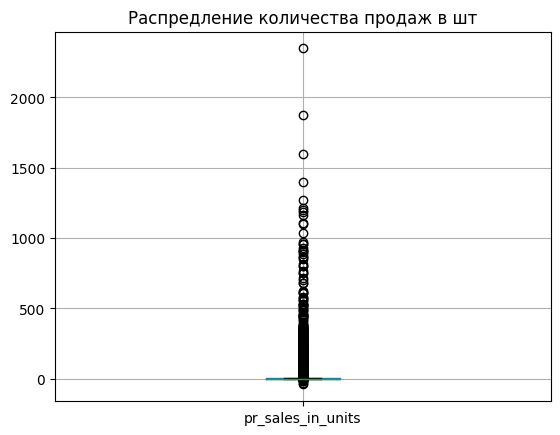

In [ ]:
sales_df_train.boxplot(column='pr_sales_in_units')
plt.title('Распредление количества продаж в шт')
plt.show()

- Распределение целевых значений отличается от нормального.
- Наблюдаются значительные выбросы.
- Присутстсуют отрицательные значения.

In [ ]:
len(sales_df_train.loc[sales_df_train.pr_sales_in_units < 0])

71

Данные наблюдения могут соответствовать случаю возврата товара или ошибки в данных. В любом случае, данные наблюдения следует удалить из выборки, к тому же их менее 0.001%.

In [ ]:
sales_df_train = sales_df_train.loc[sales_df_train.pr_sales_in_units >= 0]

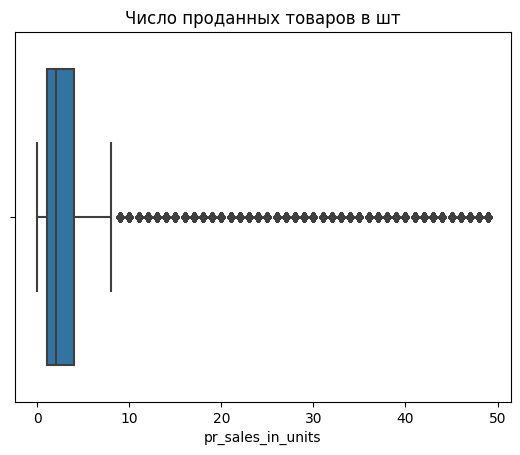

In [ ]:
sns.boxplot(x=sales_df_train[sales_df_train['pr_sales_in_units']<50]['pr_sales_in_units']).set_title('Число проданных товаров в шт')
plt.show()

Большая часть продаж - от 1 до 10 шт. И далее следует очень длинный хвост из всё возрастающего количества продаж.

Посмотрим, как выглядит топ продаж.

In [ ]:
#сгруппируем по дате, магазину, товару и флагу наличия промо
top_sales = sales_df_train.groupby(['date', 'pr_sku_id', 'pr_sales_type_id'],  as_index=False).agg(
    pr_sales_in_units_total=("pr_sales_in_units", "sum"),
    st_id_count =("st_id", "count")
)
top_sales.sort_values(by = 'pr_sales_in_units_total', ascending=False).head(20)

date                         pr_sku_id  pr_sales_type_id  \
301850 2023-04-15  5af7d2c94cb126b9cd5b485c4a0732fc                 1   
302194 2023-04-15  9aa7008fa27151bf77be5f4c9d023d5f                 1   
300890 2023-04-14  9aa7008fa27151bf77be5f4c9d023d5f                 1   
300561 2023-04-14  5af7d2c94cb126b9cd5b485c4a0732fc                 1   
178061 2022-12-30  ced0c1a84924c982a6403870c54b99ca                 0   
179421 2022-12-31  ced0c1a84924c982a6403870c54b99ca                 0   
299609 2023-04-13  9aa7008fa27151bf77be5f4c9d023d5f                 1   
274171 2023-03-23  4b083e10f6cd2f4360c5425d05be6386                 1   
241586 2023-02-24  4b083e10f6cd2f4360c5425d05be6386                 1   
299289 2023-04-13  5af7d2c94cb126b9cd5b485c4a0732fc                 1   
240350 2023-02-23  4b083e10f6cd2f4360c5425d05be6386                 1   
242795 2023-02-25  4b083e10f6cd2f4360c5425d05be6386                 1   
110228 2022-11-04  641e167f974d1dd076c0886d17271975                 1   
298408 2023-04-12  9aa7008fa27151bf77be5f4c9d023d5f                 1   
303113 2023-04-16  5af7d2c94cb126b9cd5b485c4a0732fc                 1   
275330 2023-03-24  4b083e10f6cd2f4360c5425d05be6386                 1   
300682 2023-04-14  6d6ca571e2a7d2ec70bd9c09aac38f92                 1   
179357 2022-12-31  c0e3f3bd815a862433bc3399c487926b                 0   
297221 2023-04-11  9aa7008fa27151bf77be5f4c9d023d5f                 1   
315663 2023-04-27  4b083e10f6cd2f4360c5425d05be6386                 1   

        pr_sales_in_units_total  st_id_count  
301850                   6553.0            7  
302194                   5998.0            6  
300890                   5246.0            6  
300561                   4775.0            7  
178061                   3718.0            7  
179421                   3577.0            7  
299609                   3160.0            6  
274171                   2677.0            6  
241586                   2552.0            6  
299289                   2427.0            7  
240350                   2253.0            6  
242795                   2205.0            6  
110228                   1996.0            6  
298408                   1908.0            6  
303113                   1461.0            7  
275330                   1444.0            6  
300682                   1418.0            6  
179357                   1351.0            5  
297221                   1340.0            6  
315663                   1312.0            6

Рекордное число проданных товаров пришлось на период Пасхи (середина апреля) и на предновогодний период. Причем на Пасху продажи сопровождались промо, а на Новый год - нет.

Интересно посмотреть, как эти два продукта вели себя в течение года.

<Figure size 2000x700 with 0 Axes>

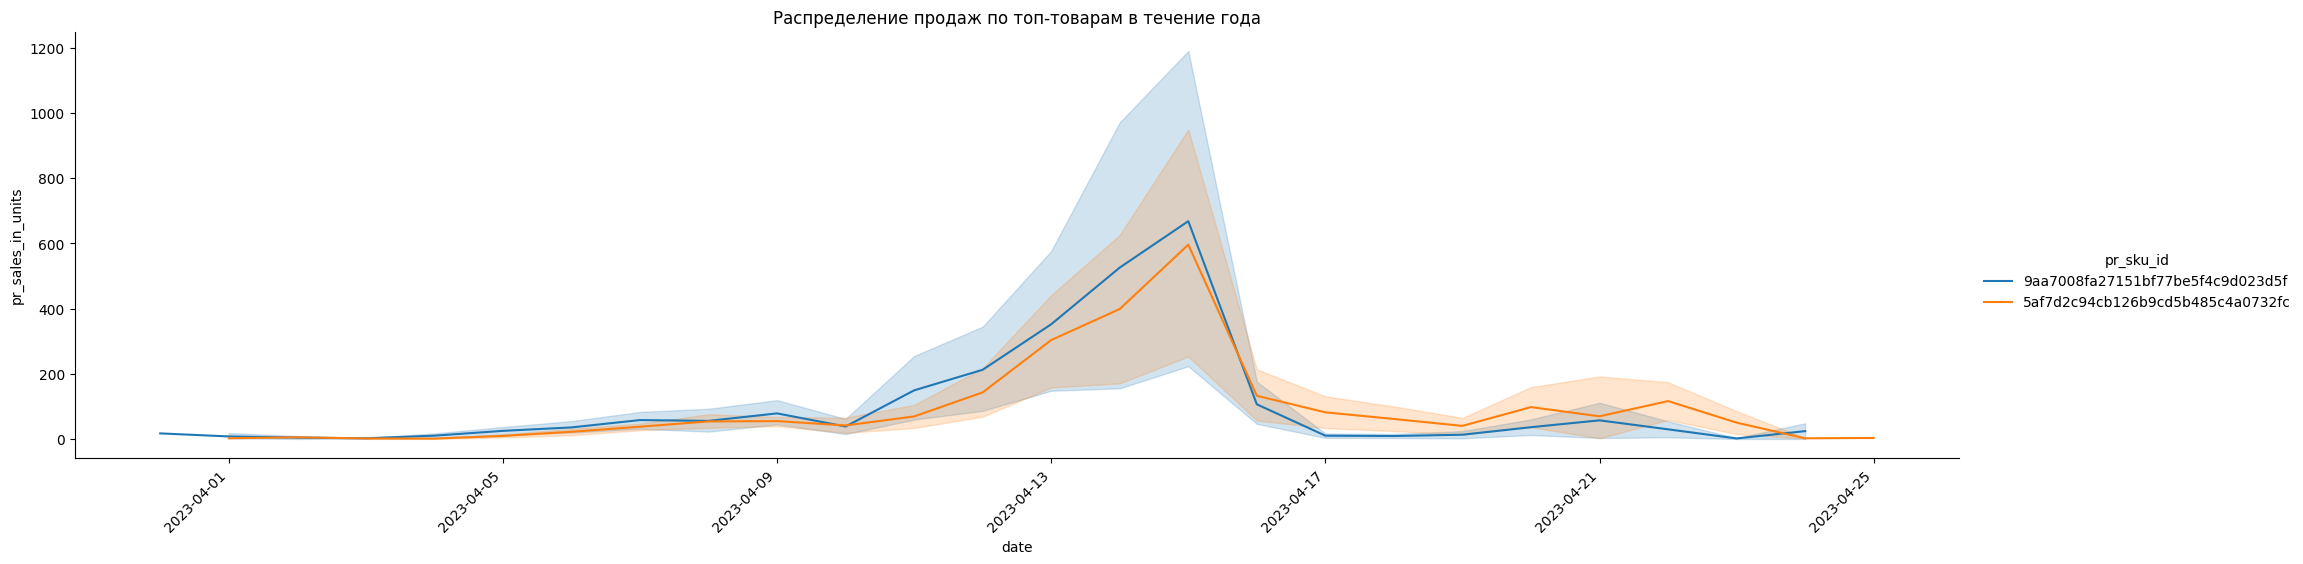

In [ ]:
plt.figure(figsize=(20, 7))

g = sns.relplot(
    data=sales_df_train[sales_df_train.pr_sku_id.isin(['5af7d2c94cb126b9cd5b485c4a0732fc',
                                                               '9aa7008fa27151bf77be5f4c9d023d5f'])]
    .sort_values(by='date'),
    x="date",
    y="pr_sales_in_units",
    hue="pr_sku_id",
    #legend = False,
    kind="line",
    aspect=4
)

g.set_xticklabels(rotation=45, horizontalalignment="right")
plt.title('Распределение продаж по топ-товарам в течение года')
plt.show()

Продажи только в течение апреля (период Пасхи).

Теперь посмотрим на ТОП Новогодних продуктов.

<Figure size 2000x900 with 0 Axes>

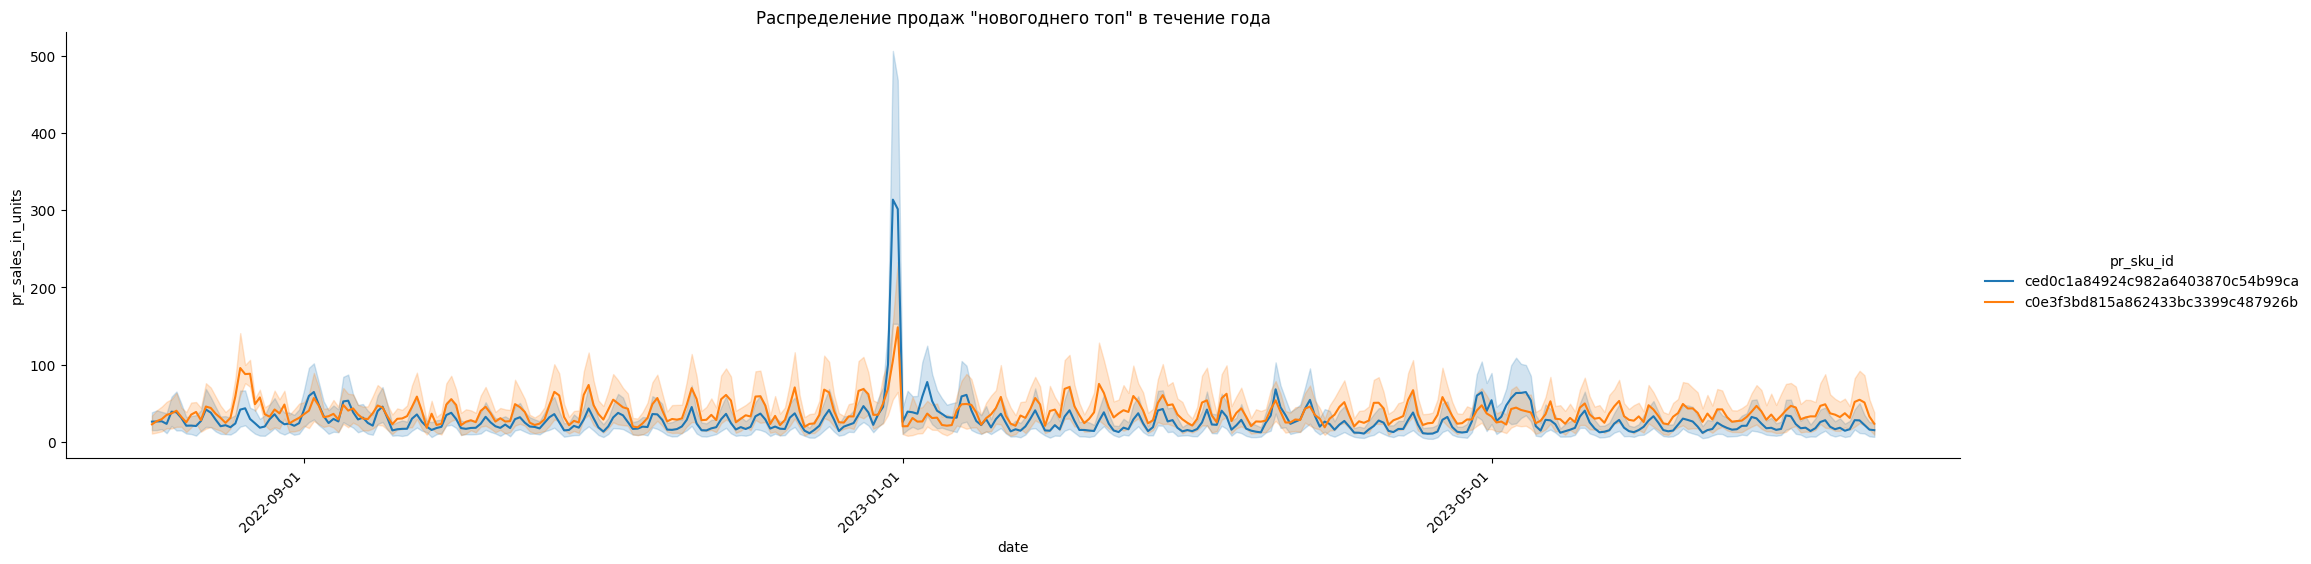

In [ ]:
plt.figure(figsize=(20, 9))

g = sns.relplot(
    data=sales_df_train[sales_df_train.pr_sku_id.isin(['ced0c1a84924c982a6403870c54b99ca',
                                                               'c0e3f3bd815a862433bc3399c487926b'])]
    .sort_values(by='date'),
    x="date",
    y="pr_sales_in_units",
    hue="pr_sku_id",
    #legend = False,
    kind="line",
    aspect=4
)

g.set_xticklabels(rotation=45, horizontalalignment="right", step=2)
plt.title('Распределение продаж "новогоднего топ" в течение года')
plt.show()

Более стабильный спрос на протяжении всего года, с всплеском на Новый год.

<Figure size 2000x900 with 0 Axes>

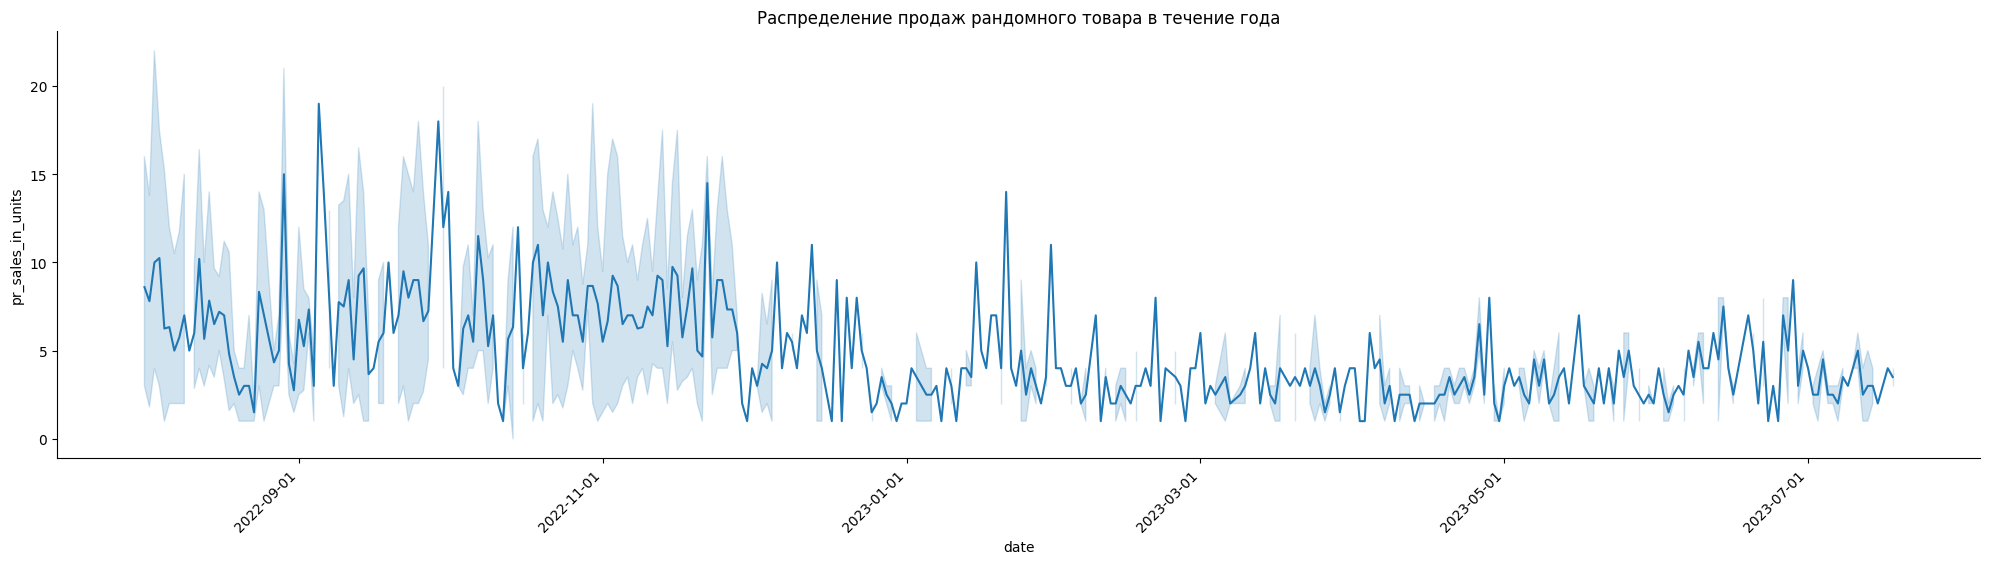

In [ ]:
plt.figure(figsize=(20, 9))

g = sns.relplot(
    data=sales_df_train[sales_df_train.pr_sku_id.isin(['00b72c2f01a1512cbb1d3f33319bac93'])]
    .sort_values(by='date'),
    x="date",
    y="pr_sales_in_units",
    hue="pr_sku_id",
    legend = False,
    kind="line",
    aspect=4
)

g.set_xticklabels(rotation=45, horizontalalignment="right", step=1)
plt.title('Распределение продаж рандомного товара в течение года')
plt.show()

Интересно: активный спрос осенью 2022 года, который затем снизился с 2023 года.

### Анализ продаж в шт

In [ ]:
promo_eda = pd.DataFrame(sales_df_train.groupby(['st_id', 'pr_sales_type_id'])['pr_sales_in_units'].agg(count=('count'))).reset_index()
promo_plot = promo_eda.loc[promo_eda.pr_sales_type_id == 0]\
                        .merge(promo_eda.loc[promo_eda.pr_sales_type_id == 1], on='st_id')\
                        .drop(['pr_sales_type_id_x', 'pr_sales_type_id_y'], axis=1)\
                        .rename(columns={'count_x':'всего продано, шт.',
                                         'count_y':'продано по промо, шт.'})\
                        .sort_values('всего продано, шт.', ascending=False)
promo_plot

st_id  всего продано, шт.  \
9   c81e728d9d4c2f636f067f89cc14862c               97958   
1   16a5cdae362b8d27a1d8f8c7b78b4330               97640   
4   42a0e188f5033bc65bf8d78622277c4e               80373   
10  f7e6c85504ce6e82442c770f7c8606f0               78873   
11  fa7cdfad1a5aaf8370ebeda47a1ff1c3               69503   
7   6364d3f0f495b6ab9dcf8d3b5c6e0b01               67334   
3   1ecfb463472ec9115b10c292ef8bc986               26749   
5   53e19f3dbb211f20b20b45668303c1b6                4166   
8   bd470ca955d9497bbcb808e59952fffc                 905   
2   1aa057313c28fa4a40c5bc084b11d276                 524   
0   084a8a9aa8cced9175bd07bc44998e75                  18   
6   62f91ce9b820a491ee78c108636db089                   3   

    продано по промо, шт.  
9                   76710  
1                   59890  
4                   59905  
10                  45265  
11                  41028  
7                   48480  
3                   20652  
5                    5065  
8                    1681  
2                     195  
0                      20  
6                       7

In [ ]:
px.bar(promo_plot,
       x=promo_plot.st_id,
       y=['всего продано, шт.',
          'продано по промо, шт.'],
       barmode="group",
       title='Соотношение количества промо акций')

### Анализ продаж в деньгах

In [ ]:
promo_sales = sales_df_train.groupby('st_id')[['pr_sales_in_rub', 'pr_promo_sales_in_rub']].sum().reset_index()
promo_sales = promo_sales.rename(columns={'pr_sales_in_rub' : 'Продано всего',\
                           'pr_promo_sales_in_rub':'Продано с промоакциeй'})\
                         .sort_values('Продано всего', ascending=False)
promo_sales

st_id  Продано всего  Продано с промоакциeй
9   c81e728d9d4c2f636f067f89cc14862c    110214900.0             52251122.0
1   16a5cdae362b8d27a1d8f8c7b78b4330    108555870.0             54128060.0
4   42a0e188f5033bc65bf8d78622277c4e     91272463.0             49343239.0
10  f7e6c85504ce6e82442c770f7c8606f0     76250074.0             35468525.0
7   6364d3f0f495b6ab9dcf8d3b5c6e0b01     65854496.0             35309998.0
11  fa7cdfad1a5aaf8370ebeda47a1ff1c3     65016015.0             30128323.0
3   1ecfb463472ec9115b10c292ef8bc986      8354660.0              2910417.0
5   53e19f3dbb211f20b20b45668303c1b6      1084411.0               564544.0
8   bd470ca955d9497bbcb808e59952fffc       256887.0               179271.0
2   1aa057313c28fa4a40c5bc084b11d276        65693.0                13497.0
0   084a8a9aa8cced9175bd07bc44998e75         6836.0                 3305.0
6   62f91ce9b820a491ee78c108636db089         3498.0                 2631.0

In [ ]:
px.bar(promo_sales,
       x=promo_sales.st_id,
       y=['Продано всего', 'Продано с промоакциeй'],
       barmode="group",
       title='Соотношение объема продаж и продаж по промо акциям в рублях')

**Вывод по таблице**

В таблице содержатся данные о покупках продукции собственного производства за период с 01 августа 2022 года по 18 июля 2023 года, пропуски в датах отсутствуют.

В продажах присутствуют отрицательные величины в количестве:
- pr_promo_sales_in_rub - 36 строк
- pr_sales_in_rub - 78 строк
- pr_promo_sales_in_units - 35 строк
- pr_sales_in_units - 71 строка

Данные с отрицательными значениями будут исключены.

Общий объем продаж в штуках относительно продаж по промоакциям составляет от 50 до 70%, при этом в рублях это составляет в среднем 50% от общего объема продаж.

## Анализ таблицы `pr_df`

pr_df.csv – данные по товарной иерархии.

Столбцы:
- pr_group_id – захэшированная группа товара;
- pr_cat_id – захэшированная категория товара;
- pr_subcat_id – захэшированная подкатегория товара;
- pr_sku_id – захэшированное id товара;
- pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).

In [ ]:
pr_df.sample(10)

pr_sku_id                       pr_group_id  \
111   1b554caad50131478083eb6e4f7845d6  c20ad4d76fe97759aa27a0c99bff6710   
2004  59aa5ee6b6b938a63e017bdfc882b51a  c74d97b01eae257e44aa9d5bade97baf   
1761  8a83012840a59f8e2edf61d9f7a38982  c74d97b01eae257e44aa9d5bade97baf   
493   8bb88fc297188331e5252b5d43747043  aab3238922bcc25a6f606eb525ffdc56   
1620  b688e55fb702f9522be5a2b536220ab5  aab3238922bcc25a6f606eb525ffdc56   
1475  7c29297f4683f2044ef345a4e8830eda  3c59dc048e8850243be8079a5c74d079   
1822  8a878d81fc03cb17da03de99b499a8a5  aab3238922bcc25a6f606eb525ffdc56   
723   4b25076d2e052e73f99b84259335a290  c74d97b01eae257e44aa9d5bade97baf   
640   2be0764e286cb615f0f8022436777baa  c74d97b01eae257e44aa9d5bade97baf   
837   d84357079260a0bb22da7c2bd4d701c6  aab3238922bcc25a6f606eb525ffdc56   

                             pr_cat_id                      pr_subcat_id  \
111   fb2fcd534b0ff3bbed73cc51df620323  8654269aab578fbbd83a0e5ef04532b4   
2004  7a6a74cbe87bc60030a4bd041dd47b78  ad2965656853a9c15c7179f5740852cf   
1761  faafda66202d234463057972460c04f5  abb6e58e590a2ae1eca80967eefe7f8b   
493   9701a1c165dd9420816bfec5edd6c2b1  c01c475ac8d447730ece97d846cc4f25   
1620  46771d1f432b42343f56f791422a4991  886f208d861792df9ccfb9793263394d   
1475  e7e23670481ac78b3c4122a99ba60573  2436c3d38e177af04fe2f19e9281c613   
1822  9701a1c165dd9420816bfec5edd6c2b1  a98ba70a6aaa1d3da549927a4ca79dfa   
723   a368b0de8b91cfb3f91892fbf1ebd4b2  8feef08314d477a5b68ba18a6d35819d   
640   a14ac55a4f27472c5d894ec1c3c743d2  470aca6acd869e1ded34eaaca3334ca5   
837   46771d1f432b42343f56f791422a4991  886f208d861792df9ccfb9793263394d   

      pr_uom_id  
111           1  
2004         17  
1761         17  
493           1  
1620         17  
1475          1  
1822          1  
723           1  
640          17  
837          17

In [ ]:
pr_df.isna().mean()*100

pr_sku_id       0.0
pr_group_id     0.0
pr_cat_id       0.0
pr_subcat_id    0.0
pr_uom_id       0.0
dtype: float64

In [ ]:
pr_df.describe()

pr_uom_id
count  2050.000000
mean      7.017561
std       7.752371
min       1.000000
25%       1.000000
50%       1.000000
75%      17.000000
max      17.000000

## Анализ таблицы `st_df`

st_df.csv – данные по магазинам.

Столбцы:
- st_id – захэшированное id магазина;
- st_city_id – захэшированное id города;
- st_division_code id – захэшированное id дивизиона;
- st_type_format_id – id формата магазина;
- st_type_loc_id – id тип локации/окружения магазина;
- st_type_size_id – id типа размера магазина;
- st_is_active – флаг активного магазина на данный момент.

In [ ]:
st_df.sample(10)

st_id                        st_city_id  \
6   42a0e188f5033bc65bf8d78622277c4e  b8b4b727d6f5d1b61fff7be687f7970f   
11  084a8a9aa8cced9175bd07bc44998e75  3202111cf90e7c816a472aaceb72b0df   
3   1ecfb463472ec9115b10c292ef8bc986  908c9a564a86426585b29f5335b619bc   
9   f7e6c85504ce6e82442c770f7c8606f0  3202111cf90e7c816a472aaceb72b0df   
8   fa7cdfad1a5aaf8370ebeda47a1ff1c3  885fe656777008c335ac96072a45be15   
0   1aa057313c28fa4a40c5bc084b11d276  1587965fb4d4b5afe8428a4a024feb0d   
5   53e19f3dbb211f20b20b45668303c1b6  955d864a62659945cc9434898e275deb   
1   bd470ca955d9497bbcb808e59952fffc  955d864a62659945cc9434898e275deb   
7   c81e728d9d4c2f636f067f89cc14862c  908c9a564a86426585b29f5335b619bc   
4   16a5cdae362b8d27a1d8f8c7b78b4330  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                    st_division_code  st_type_format_id  st_type_loc_id  \
6   da742b3cfca5388aaf9af28a726a3c30                  1               1   
11  32586311f16876abf92901085bd87b99                  4               3   
3   429a86ff6336c144ddaf6144f52ab52c                  2               1   
9   32586311f16876abf92901085bd87b99                  1               1   
8   296bd0cc6e735f9d7488ebc8fbc19130                  1               1   
0   81b4dd343f5880df806d4c5d4a846c64                  4               3   
5   e26072c92d8fe0738df44d571d5f5e8b                  4               3   
1   e26072c92d8fe0738df44d571d5f5e8b                  4               3   
7   429a86ff6336c144ddaf6144f52ab52c                  1               1   
4   296bd0cc6e735f9d7488ebc8fbc19130                  1               2   

    st_type_size_id  st_is_active  
6                12             1  
11               19             1  
3                28             1  
9                12             1  
8                12             1  
0                19             0  
5                20             1  
1                19             1  
7                 8             1  
4                 8             1

In [ ]:
st_df.isna().mean()*100

st_id                0.0
st_city_id           0.0
st_division_code     0.0
st_type_format_id    0.0
st_type_loc_id       0.0
st_type_size_id      0.0
st_is_active         0.0
dtype: float64

In [ ]:
st_df.describe()

st_type_format_id  st_type_loc_id  st_type_size_id  st_is_active
count          12.000000       12.000000        12.000000     12.000000
mean            2.333333        1.916667        16.750000      0.833333
std             1.497473        0.996205         7.557356      0.389249
min             1.000000        1.000000         8.000000      0.000000
25%             1.000000        1.000000        12.000000      1.000000
50%             1.500000        1.500000        15.500000      1.000000
75%             4.000000        3.000000        19.250000      1.000000
max             4.000000        3.000000        32.000000      1.000000

### Столбец `city_group`

In [ ]:
city_group = st_df.groupby('st_city_id')['st_type_format_id'].agg(count=('count')).reset_index().sort_values('count', ascending=False)
city_group

st_city_id  count
0  1587965fb4d4b5afe8428a4a024feb0d      2
1  3202111cf90e7c816a472aaceb72b0df      2
3  908c9a564a86426585b29f5335b619bc      2
4  955d864a62659945cc9434898e275deb      2
5  b8b4b727d6f5d1b61fff7be687f7970f      2
2  885fe656777008c335ac96072a45be15      1
6  c1f75cc0f7fe269dd0fd9bd5e24f9586      1

In [ ]:
px.bar(city_group, x='st_city_id', y='count')

### Столбец `st_is_active`

In [ ]:
len(st_df.loc[st_df['st_is_active'] == 0])

2

2 магазина из 7 являются закрытыми. Данные по ним будут исключены из датасета.

## Таблица sales_submission

In [ ]:
sales_submission.sample(10)

st_id                         pr_sku_id  \
786    42a0e188f5033bc65bf8d78622277c4e  2f72f7c5dae106c917edff70a3b1ac1f   
16337  42a0e188f5033bc65bf8d78622277c4e  13e760924d65bba3dce3393d3185abd3   
1370   6364d3f0f495b6ab9dcf8d3b5c6e0b01  4a15a652bde1a9a3ac9cb96160ff3a98   
8977   fa7cdfad1a5aaf8370ebeda47a1ff1c3  246db71cccfbfbfaef328f1f8f7df31e   
9761   16a5cdae362b8d27a1d8f8c7b78b4330  bea5b83d3a056039813089e7aa7f7e9a   
5098   c81e728d9d4c2f636f067f89cc14862c  79a7b3ad0fea538681d6adcb3b46024d   
23751  c81e728d9d4c2f636f067f89cc14862c  5bc0e44accee3ad26b2a39c3b2bf91fc   
27040  c81e728d9d4c2f636f067f89cc14862c  a874ea75090fb2b9b80aa286e3ecb2d9   
7144   42a0e188f5033bc65bf8d78622277c4e  67797f1f0f02ec5ccd5e3abd2d4e5b81   
22197  16a5cdae362b8d27a1d8f8c7b78b4330  a581d2f386cfba4af577094ec9c736c8   

             date  target  
786    2023-07-20       0  
16337  2023-07-26       0  
1370   2023-07-20       0  
8977   2023-07-22       0  
9761   2023-07-24       0  
5098   2023-07-21       0  
23751  2023-07-28       0  
27040  2023-07-19       0  
7144   2023-07-22       0  
22197  2023-07-28       0

Файл, в который необходимо положить данные для вывода на экран в интерфейсе, предсказание будет заменять 0 в столбце `target`.

Соотнесение перечня товаров в submission и основном датасете.

In [ ]:
sub_sku_id = sales_submission.pr_sku_id.unique().tolist()
sales_sku_id = sales_df_train.pr_sku_id.unique().tolist()

In [ ]:
ok = []
not_ok = []
for i in sub_sku_id:
    if i in sales_sku_id:
        ok.append(i)
    else:
        not_ok.append(i)

In [ ]:
len(sub_sku_id)

1087

In [ ]:
len(ok), len(not_ok)

(1028, 59)

In [ ]:
pr_df_sku_id = pr_df_sku_id = pr_df.pr_sku_id.unique().tolist()

In [ ]:
ok = []
not_ok = []
for i in sub_sku_id:
    if i in pr_df_sku_id:
        ok.append(i)
    else:
        not_ok.append(i)

In [ ]:
len(ok), len(not_ok)

(1087, 0)

В основных данных отсутствует информация о 59 товарах из submission, они присутствуют только в таблице pr_df.

## Объединение таблиц и общий анализ данных

### Объединение таблиц

In [ ]:
full_data = pd.merge(sales_df_train,pr_df, how='left', on='pr_sku_id')
full_data = pd.merge(full_data,st_df, how='left', on='st_id')

Изменим расположение признаков в данных

In [ ]:
full_data = full_data[['date',
                       'st_id',
                       'st_city_id',
                       'st_division_code',
                       'st_type_format_id',
                       'st_type_loc_id',
                       'st_type_size_id',
                       'st_is_active',
                       'pr_sku_id',
                       'pr_group_id',
                       'pr_cat_id',
                       'pr_subcat_id',
                       'pr_uom_id',
                       'pr_sales_type_id',
                       'pr_sales_in_units',
                       'pr_promo_sales_in_units',
                       'pr_sales_in_rub',
                       'pr_promo_sales_in_rub']]

Преобразуем тип данных признака `date`

Приведём категориальные признаки к типу данных *object*

In [ ]:
for column in ['st_type_format_id',
               'st_type_loc_id',
               'st_type_size_id',
               'st_is_active',
               'pr_uom_id',
               'pr_sales_type_id']:
    full_data[column] = full_data[column].astype(str)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882944 entries, 0 to 882943
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     882944 non-null  datetime64[ns]
 1   st_id                    882944 non-null  object        
 2   st_city_id               882944 non-null  object        
 3   st_division_code         882944 non-null  object        
 4   st_type_format_id        882944 non-null  object        
 5   st_type_loc_id           882944 non-null  object        
 6   st_type_size_id          882944 non-null  object        
 7   st_is_active             882944 non-null  object        
 8   pr_sku_id                882944 non-null  object        
 9   pr_group_id              882944 non-null  object        
 10  pr_cat_id                882944 non-null  object        
 11  pr_subcat_id             882944 non-null  object        
 12  pr_uom_id       

Отсортируем значения по временной шкале.

In [ ]:
full_data = full_data.sort_values(by='date')

### Предобработка

#### Рекомендация бизнеса №1

Наблюдения, в которых присутствует продажи в рублях, но отсутствуют данные о количество проданного товара, удалим из выборки по рекомендации бизнес-заказчика, т.к. природа таких даных неизвестна.

In [ ]:
full_data = full_data.loc[~(full_data.pr_sales_in_units==0)&(full_data.pr_sales_in_rub!=0)]

#### Рекомендация бизнеса №2

По совету бизнеса не будем учитывать неактивные магазины при прогнозировании.

In [ ]:
full_data = full_data.loc[(full_data.st_is_active=='1')]
full_data = full_data.drop('st_is_active', axis=1)

In [ ]:
full_data.pr_sku_id.nunique()

1972

Товар сохранился

#### Дублированная информация

Согласно пояснениям бизнеса данные `pr_promo_sales_in_units` и `pr_promo_sales_in_rub` обозначают общие продажи в шт и рублях. В тех случаях, когда есть промо, данные в `pr_sales_in_units` и `pr_sales_in_rub` дублируют колонки с общими продажали. Соответственно можем удалить эти признаки.

In [ ]:
full_data = full_data.drop(['pr_promo_sales_in_units', 'pr_promo_sales_in_rub'], axis=1)

### Распредление продаж по группам товара в течение года

Посмотрим на части данных, как происходит распределение продаж по разным группам товаров.

<Figure size 2000x500 with 0 Axes>

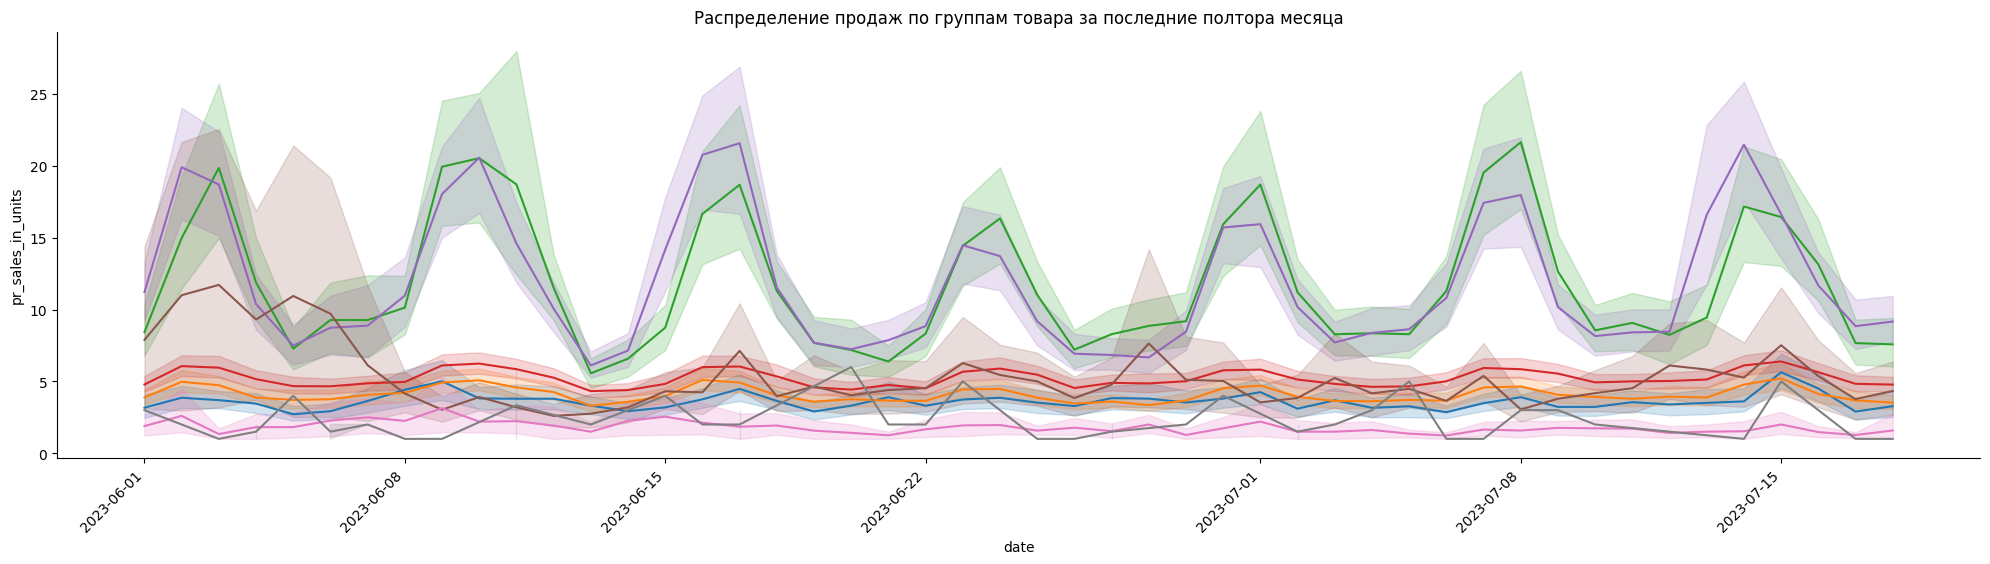

In [ ]:
plt.figure(figsize=(20, 5))

g = sns.relplot(
    data=full_data[full_data['date'] >= '2023-06-01'],
    x="date",
    y="pr_sales_in_units",
    hue="pr_group_id",
    legend = False,
    kind="line",
    aspect=4,
)

g.set_xticklabels(rotation=45, horizontalalignment="right", step=1)
plt.title('Распределение продаж по группам товара за последние полтора месяца')
plt.show()

Видим, что есть группы товаров с ярко выраженной сезонностью, тогда как у некоторых групп продажи более плавные и сезонность и так выражена.

### Топ товаров по магазинам

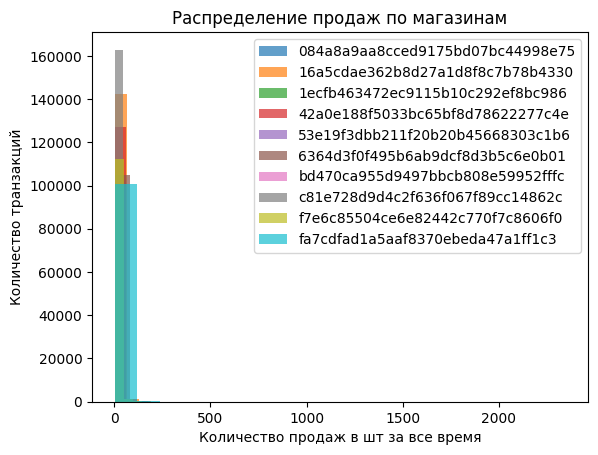

In [ ]:
full_data.groupby('st_id')['pr_sales_in_units'].plot(kind='hist', bins=20, alpha=0.7)
plt.legend()
plt.xlabel('Количество продаж в шт за все время')
plt.ylabel('Количество транзакций')
plt.title('Распределение продаж по магазинам')
plt.show()

Распределение очень похоже на то, как в целом распределяется таргетный признак - большая часть приходится на совсем небольшие продажи, и затем следует длинный хвост из более крупных продаж.

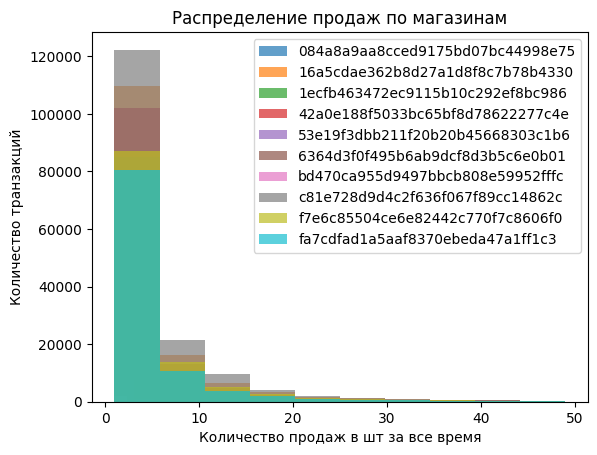

In [ ]:
full_data[full_data['pr_sales_in_units']<50].groupby('st_id')['pr_sales_in_units'].plot(kind='hist', bins=10, alpha=0.7)
plt.legend()
plt.xlabel('Количество продаж в шт за все время')
plt.ylabel('Количество транзакций')
plt.title('Распределение продаж по магазинам')
plt.show()

И наоборот, посмотрим, как распределяются рекордные продажи по магазинам.

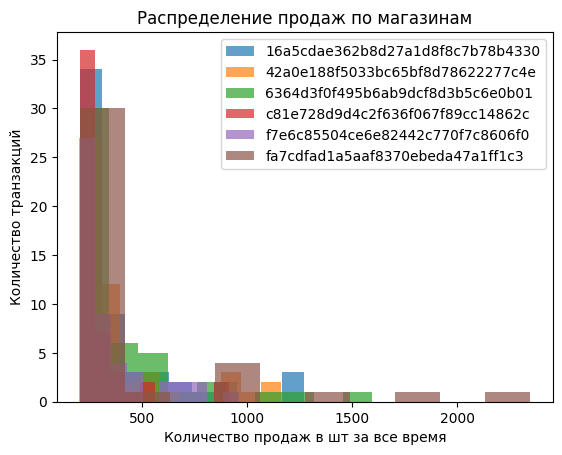

In [ ]:
full_data[full_data['pr_sales_in_units']>200].groupby('st_id')['pr_sales_in_units'].plot(kind='hist', bins=10, alpha=0.7)
plt.legend()
plt.xlabel('Количество продаж в шт за все время')
plt.ylabel('Количество транзакций')
plt.title('Распределение продаж по магазинам')
plt.show()

Распределение неравномерное, есть явные лидеры по продажам среди магазинов.

In [ ]:
products_per_st = sales_df_train.groupby(['st_id', 'pr_sku_id'],  as_index=False).agg(
    pr_sales_in_units_sum=("pr_sales_in_units", "sum"),
    pr_sales_count=("pr_sales_in_units", "count")
)

# Сортируем продукты в каждом магазине по количеству продаж и выбираем топ-10
top_roducts_per_st = products_per_st.groupby('st_id').apply(
    lambda x: x.nlargest(10, 'pr_sales_in_units_sum')).reset_index(drop=True)
top_roducts_per_st.head(25)

st_id                         pr_sku_id  \
0   084a8a9aa8cced9175bd07bc44998e75  88feeeb024d3f69da7322d76b7b53744   
1   084a8a9aa8cced9175bd07bc44998e75  c2718cfd2edcbadfe0162a4f4c91f3a0   
2   084a8a9aa8cced9175bd07bc44998e75  0376a60d9a7ce7965beddc4815588697   
3   084a8a9aa8cced9175bd07bc44998e75  c4a665596d4f67cecb7542c9fad407ee   
4   084a8a9aa8cced9175bd07bc44998e75  be8d2843456cac871fc116ab25d02994   
5   084a8a9aa8cced9175bd07bc44998e75  61ede1b712ff37c91101eed14b7a6c4f   
6   16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
7   16a5cdae362b8d27a1d8f8c7b78b4330  ced0c1a84924c982a6403870c54b99ca   
8   16a5cdae362b8d27a1d8f8c7b78b4330  cf91eca9321c9c272fb4e7cf4bcc6a43   
9   16a5cdae362b8d27a1d8f8c7b78b4330  c0e3f3bd815a862433bc3399c487926b   
10  16a5cdae362b8d27a1d8f8c7b78b4330  5aa2f6e00873f8c90b00cd15d670daa1   
11  16a5cdae362b8d27a1d8f8c7b78b4330  ae9aebfac21c0f936c47eb52ff16c32b   
12  16a5cdae362b8d27a1d8f8c7b78b4330  4e824a65fbd01f1708131bd247842688   
13  16a5cdae362b8d27a1d8f8c7b78b4330  1a0f36f6e92560bcae205b6c32cc033f   
14  16a5cdae362b8d27a1d8f8c7b78b4330  4b083e10f6cd2f4360c5425d05be6386   
15  16a5cdae362b8d27a1d8f8c7b78b4330  6e456038d557302367b91b7e0ab71e24   
16  1aa057313c28fa4a40c5bc084b11d276  62d4af457ba2540ce0898a211c0cd17a   
17  1aa057313c28fa4a40c5bc084b11d276  6b1344097385a42484abd4746371e416   
18  1aa057313c28fa4a40c5bc084b11d276  3474f0e025c7deb7e127a35763bc5512   
19  1aa057313c28fa4a40c5bc084b11d276  66a5198a8d1afbef4821b8cebf7f794d   
20  1aa057313c28fa4a40c5bc084b11d276  1cfd4c9cd7289a63dc2492f2b0200868   
21  1aa057313c28fa4a40c5bc084b11d276  231af8dc5fd5b69a7cfc4b015ebfd72a   
22  1aa057313c28fa4a40c5bc084b11d276  6e5d274636cdf86dabee3f8658794d54   
23  1aa057313c28fa4a40c5bc084b11d276  00b72c2f01a1512cbb1d3f33319bac93   
24  1aa057313c28fa4a40c5bc084b11d276  5b26f85ccb23039364226f66f0366c66   

    pr_sales_in_units_sum  pr_sales_count  
0                    16.0              14  
1                    15.0               9  
2                    10.0              10  
3                     5.0               2  
4                     2.0               2  
5                     1.0               1  
6                 51500.0             704  
7                 29678.0             678  
8                 24716.0             670  
9                 22423.0             620  
10                16735.0             620  
11                15836.0             464  
12                15717.0             464  
13                15296.0             672  
14                13840.0             317  
15                12008.0             424  
16                  201.0              35  
17                  166.0              52  
18                  141.0              25  
19                  139.0              27  
20                  109.0              25  
21                  103.0              24  
22                   99.0              21  
23                   96.0              31  
24                   94.0              38

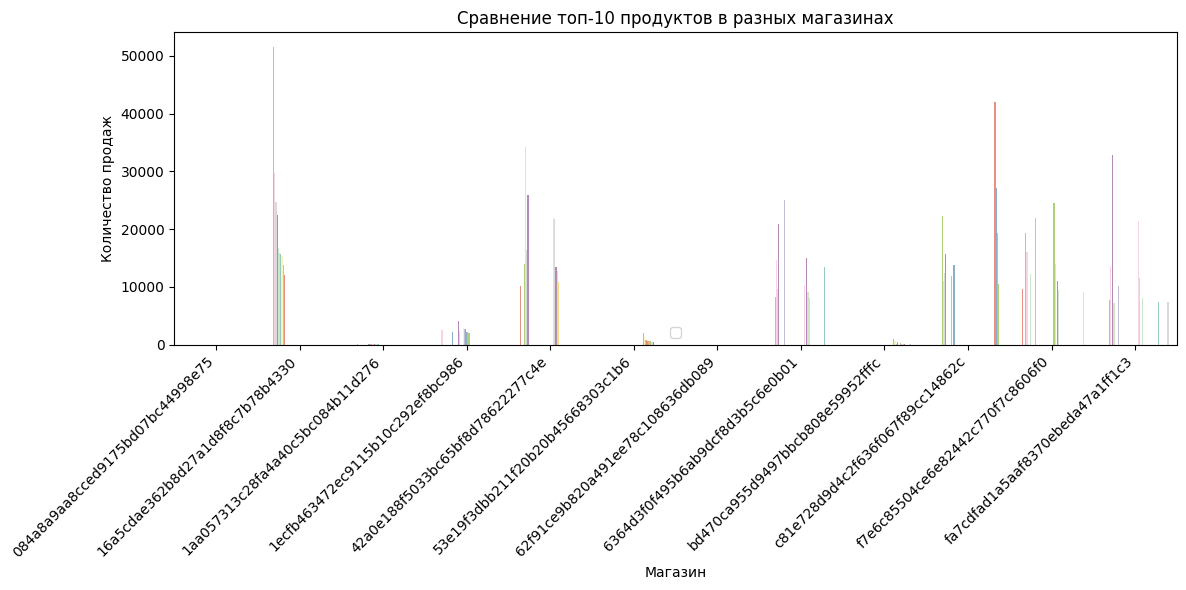

In [ ]:
# Создаем график с использованием Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=top_roducts_per_st, x='st_id', y='pr_sales_in_units_sum', hue='pr_sku_id',
            palette='Set3'
           )

# Добавляем легенду
plt.legend([])

# Добавляем подписи к осям и заголовок
plt.xlabel('Магазин')
plt.ylabel('Количество продаж')
plt.title('Сравнение топ-10 продуктов в разных магазинах')

# Поворачиваем названия продуктов на 45 градусов для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Отображаем график
plt.tight_layout()
plt.show()

## Анализ временных рядов

In [ ]:
full_data = full_data.set_index('date', drop=True)

In [ ]:
df_days_sum = full_data['pr_sales_in_units'].resample('1D').sum()
df_days_sum.tail()

date
2023-07-14    20294.0
2023-07-15    20304.0
2023-07-16    14870.0
2023-07-17    10462.0
2023-07-18    10713.0
Freq: D, Name: pr_sales_in_units, dtype: float64

Посмотрим на тренды и сезонность временного ряда в данных.

In [ ]:
decomposed_sum = seasonal_decompose(df_days_sum)

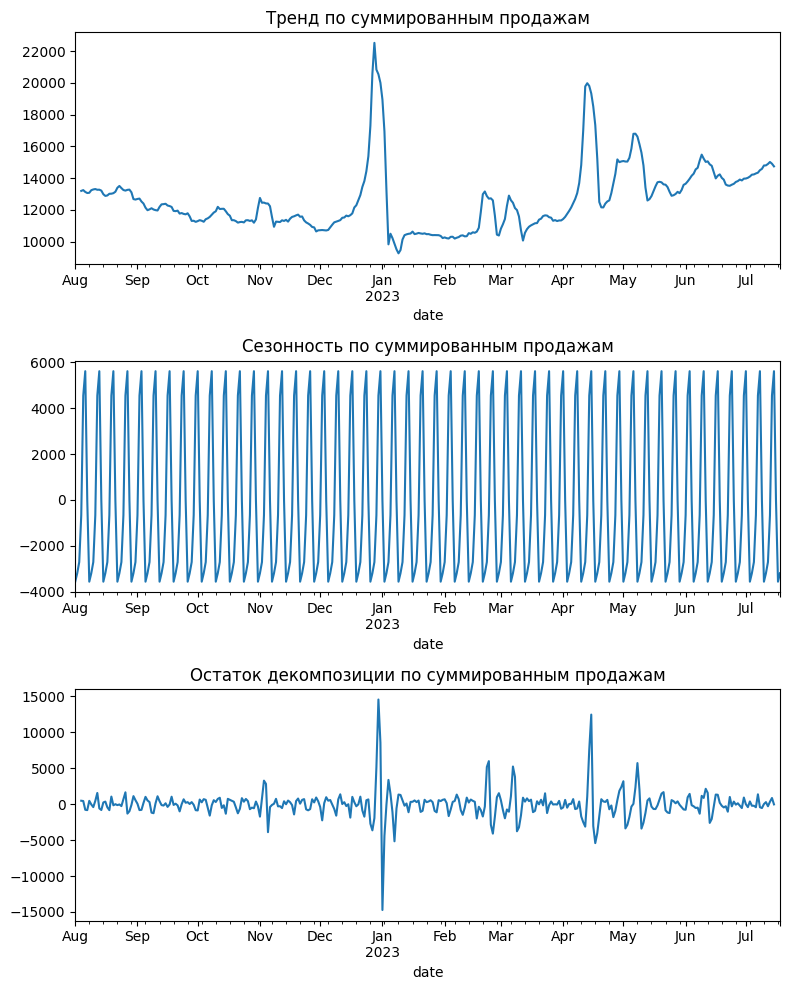

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(311)
decomposed_sum.trend.plot(ax=plt.gca())
plt.title('Тренд по суммированным продажам')

plt.subplot(312)
decomposed_sum.seasonal.plot(ax=plt.gca())
plt.title('Сезонность по суммированным продажам')

plt.subplot(313)
decomposed_sum.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции по суммированным продажам')

plt.tight_layout()
plt.show()

Наблюдается яркий тренд в связке с государственными праздниками и временем года:

- резкое возрастание продаж перед новогодними праздниками, затем такое же резкое снижение,
- всплески в районе гендерных праздников,
- скачок продаж в апреле (Пасха) и на майские праздники, затем такой же небольшой скачок в июне (День России),
- высокие продажи летом, которые постепенно затухают осенью, и только в ноябре возникает небольшой всплеск (День народного единства).

Интересно также посмотреть на остатки - на протяжении года доля остатков меняется. Наибольший шум возникает всё так же в районе главных государственных праздников.

Что касается сезонности, её нужно смотреть на более коротком промежутке. Изучим сезонность за месяц.

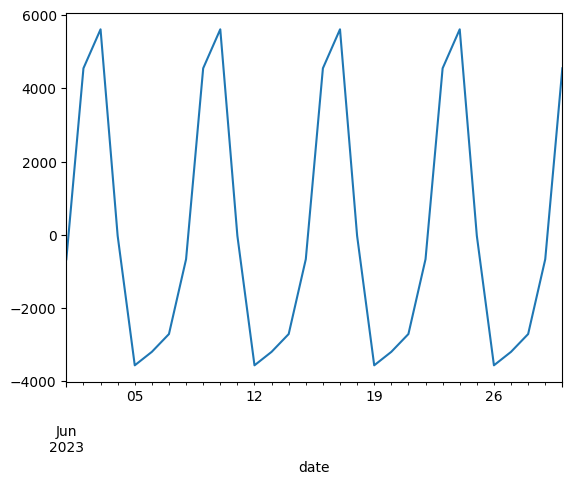

In [ ]:
decomposed_sum.seasonal['2023-06-01':'2023-06-30'].plot()
plt.show()

Видим, что в данных присутствует ярко выраженная недельная сезонность. По понедельникам самые низкие продажи, по пятницам - самые высокие. Значит, при добавлении новых признаков есть смысл добавить признак "день недели".

Теперь посмотрим по отдельным группам товаров.

In [ ]:
groups = full_data['pr_group_id'].unique()
groups

array(['c74d97b01eae257e44aa9d5bade97baf',
       'c51ce410c124a10e0db5e4b97fc2af39',
       'aab3238922bcc25a6f606eb525ffdc56',
       '6512bd43d9caa6e02c990b0a82652dca',
       '1ff1de774005f8da13f42943881c655f',
       '32bb90e8976aab5298d5da10fe66f21d',
       'c20ad4d76fe97759aa27a0c99bff6710',
       '98f13708210194c475687be6106a3b84',
       '3c59dc048e8850243be8079a5c74d079'], dtype=object)

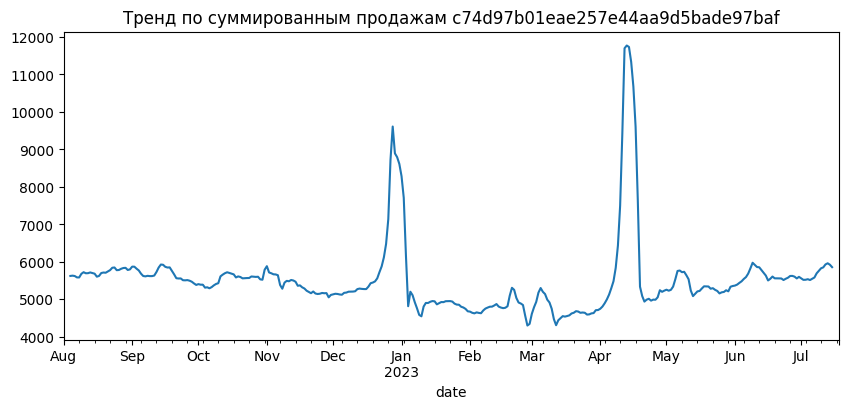

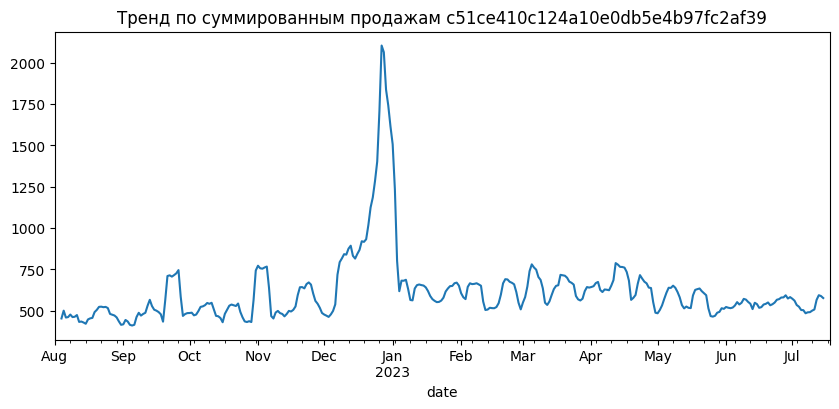

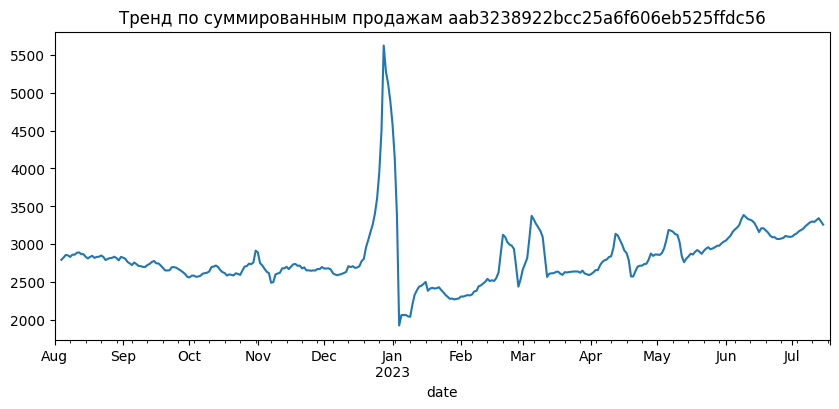

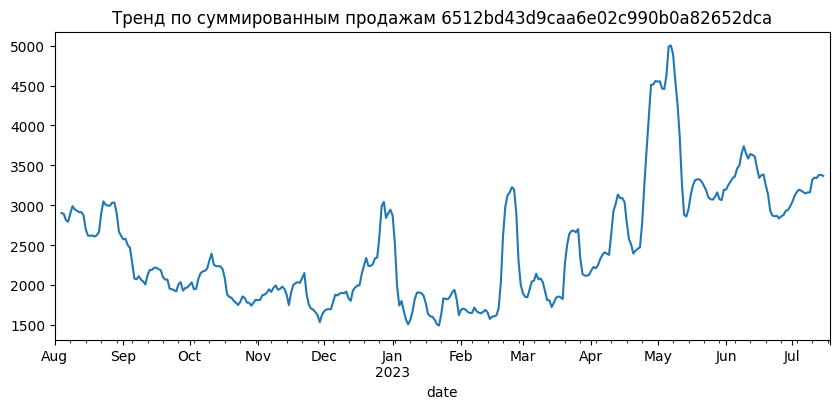

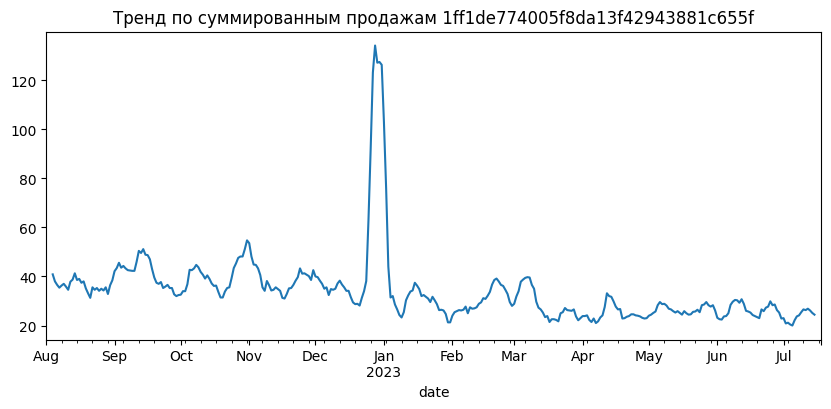

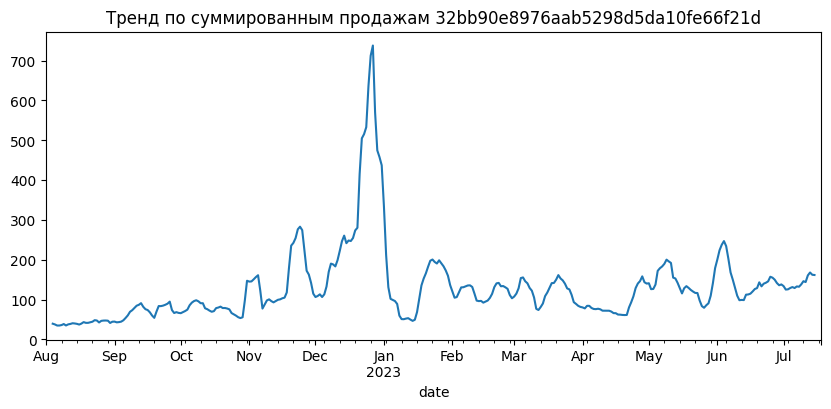

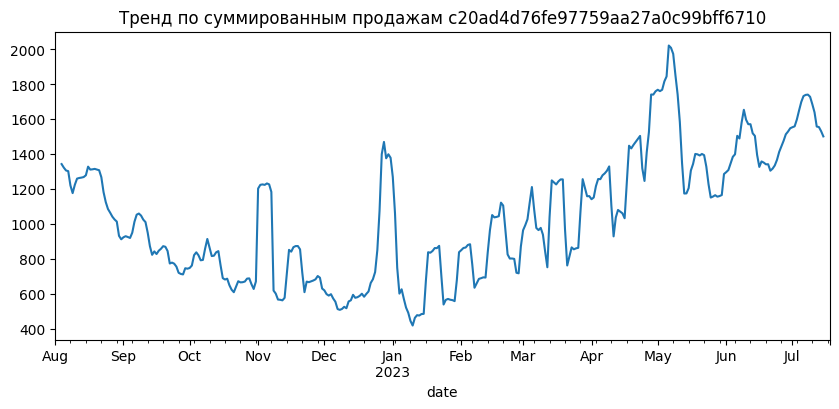

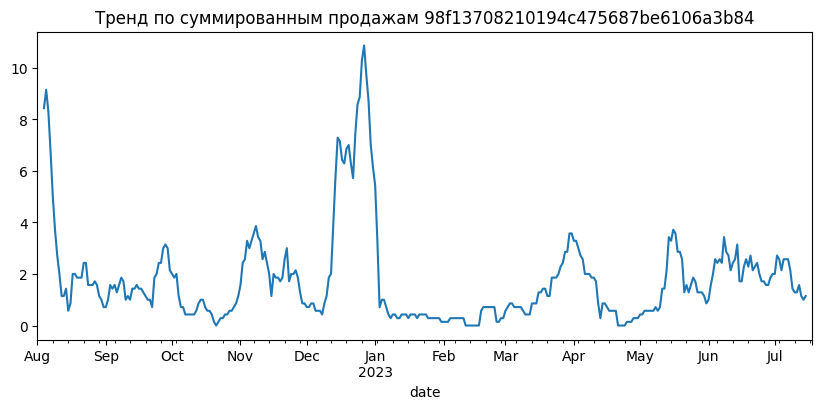

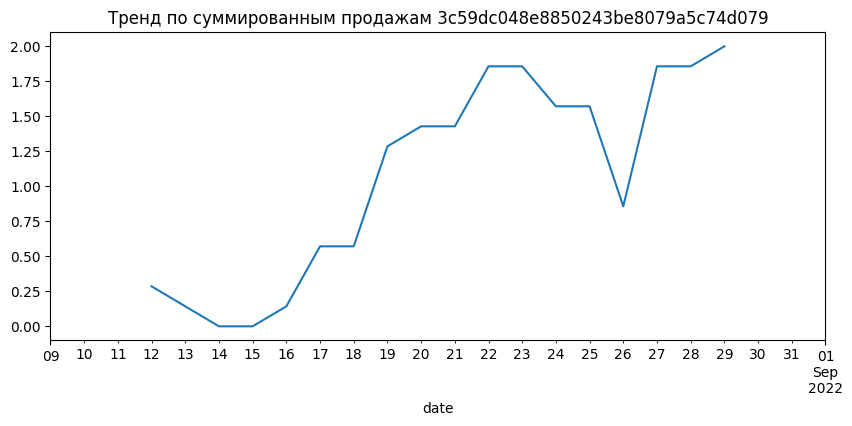

In [ ]:
for group in groups:
    resampled = full_data[
        full_data['pr_group_id']== group]['pr_sales_in_units'].resample('1D').sum()
    decomposed = seasonal_decompose(resampled)
    plt.figure(figsize=(10,4))
    decomposed.trend.plot()
    plt.title(f'Тренд по суммированным продажам {group}')
    plt.show()

Мы видим, что ряд групп имеет зависимость от праздников и времени года. Выбиваются две группы, по которыс продажи были только в августе/сентябре.

### Значимость лагов

Посмотрим на значимость лагов на автокорреляции.

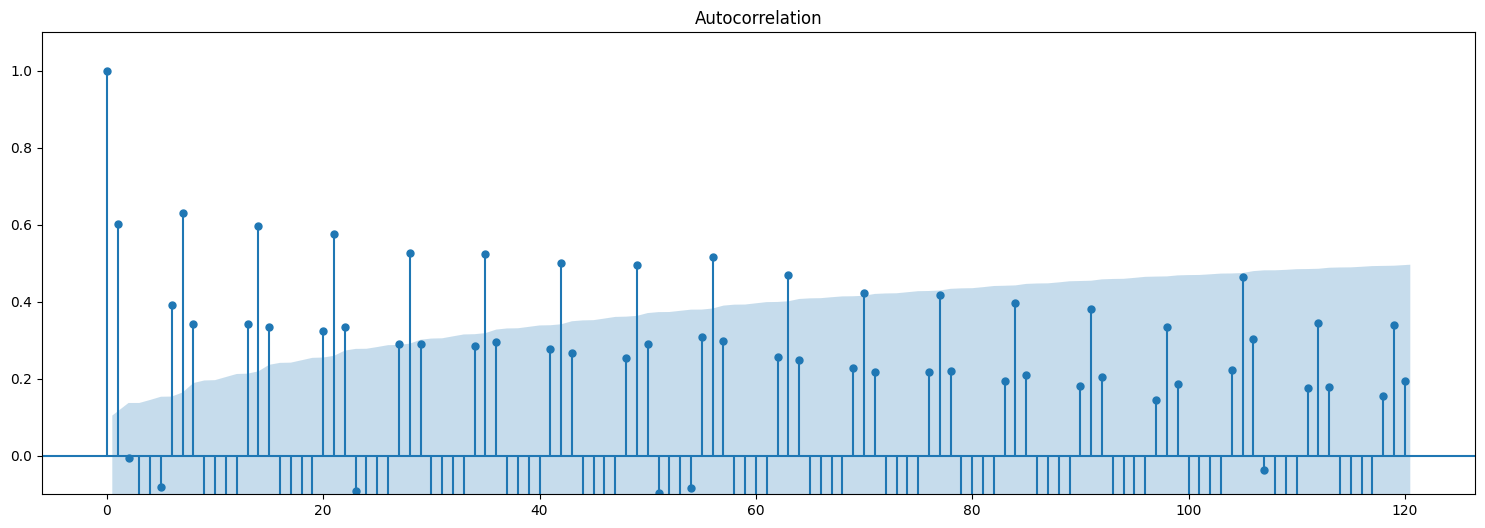

In [ ]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(df_days_sum,lags= 120)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()

Область синей заливки обозначает порог статистической значимости (если значение внутри, корреляция уже не заслуживает доверия. Стат.значимость вычисляется по тесту Стьюдента).
Таким образом мы видим, что есть смысл брать не более чем 57 лагов (8 недель).

Важное уточнение: поскольку мы предсказываем спрос на 14 дней вперед, нужно быть осторожнее при выборе размера лага. Мы не можем создавать лаги от 1 до 14, поскольку у нас нет данных о "pr_sales_in_units" из будущего. Поэтому важно создавать лаги начиная с 15-го.

## Корреляция признаков

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning:

The number of unique values of variable pr_sku_id is large: 1972. Are you sure this is not an interval variable? Analysis for pairs of variables including pr_sku_id can be slow.



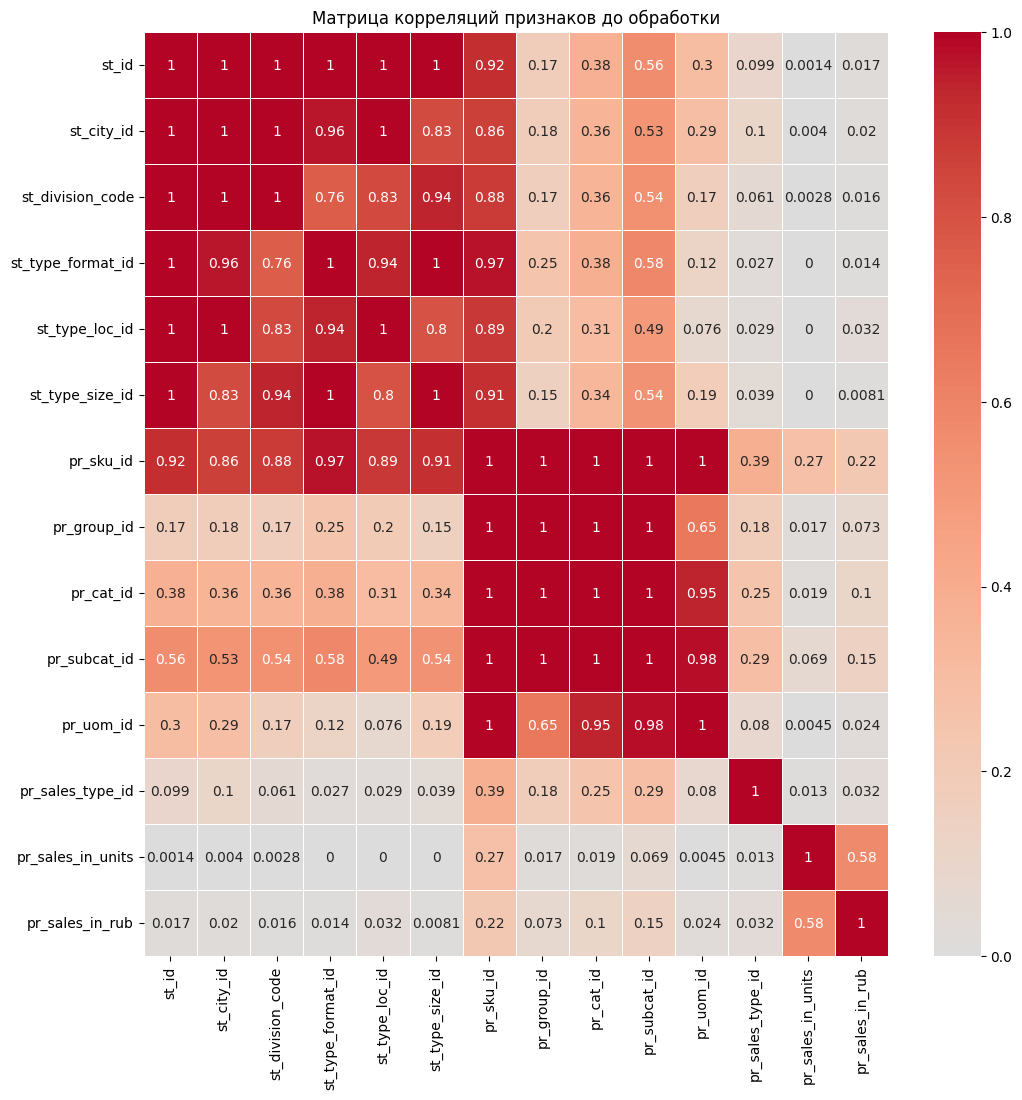

In [ ]:
int_list = ['pr_sales_in_units', 'pr_sales_in_rub']
plt.figure(figsize=(12,12))
(sns.heatmap(full_data
              .phik_matrix(interval_cols=int_list),
              annot=True,
              linewidth=.5,
              cmap='coolwarm',
              center=0)
  .set(title="Матрица корреляций признаков до обработки"))
plt.show()

Мультиколлиниарные признаки будем удалять перед подачей в модель.

### Ищем корреляцию между магазинами

In [ ]:
full_data.st_id.nunique()

10

In [ ]:
full_data.st_city_id.nunique()

6

In [ ]:
full_data.st_division_code.nunique()

5

In [ ]:
full_data.st_type_format_id.nunique()

3

In [ ]:
full_data.st_type_loc_id.nunique()

3

In [ ]:
full_data.st_type_size_id.nunique()

5

In [ ]:
full_data_shops = full_data.st_id
full_data_shops = pd.get_dummies(full_data_shops)

присоеденим таргет:

In [ ]:
full_data_shops['target'] = full_data['pr_sales_in_units']
full_data_shops.head()

084a8a9aa8cced9175bd07bc44998e75  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            16a5cdae362b8d27a1d8f8c7b78b4330  \
date                                           
2022-08-01                                 1   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 1   
2022-08-01                                 0   

            1ecfb463472ec9115b10c292ef8bc986  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            42a0e188f5033bc65bf8d78622277c4e  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 1   

            53e19f3dbb211f20b20b45668303c1b6  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            6364d3f0f495b6ab9dcf8d3b5c6e0b01  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            bd470ca955d9497bbcb808e59952fffc  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            c81e728d9d4c2f636f067f89cc14862c  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 1   
2022-08-01                                 0   
2022-08-01                                 0   

            f7e6c85504ce6e82442c770f7c8606f0  \
date                                           
2022-08-01                                 0   
2022-08-01                                 1   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            fa7cdfad1a5aaf8370ebeda47a1ff1c3  target  
date                                                  
2022-08-01                                 0     7.0  
2022-08-01                                 0     1.0  
2022-08-01                                 0     1.0  
2022-08-01                                 0     1.0  
2022-08-01                                 0     1.0

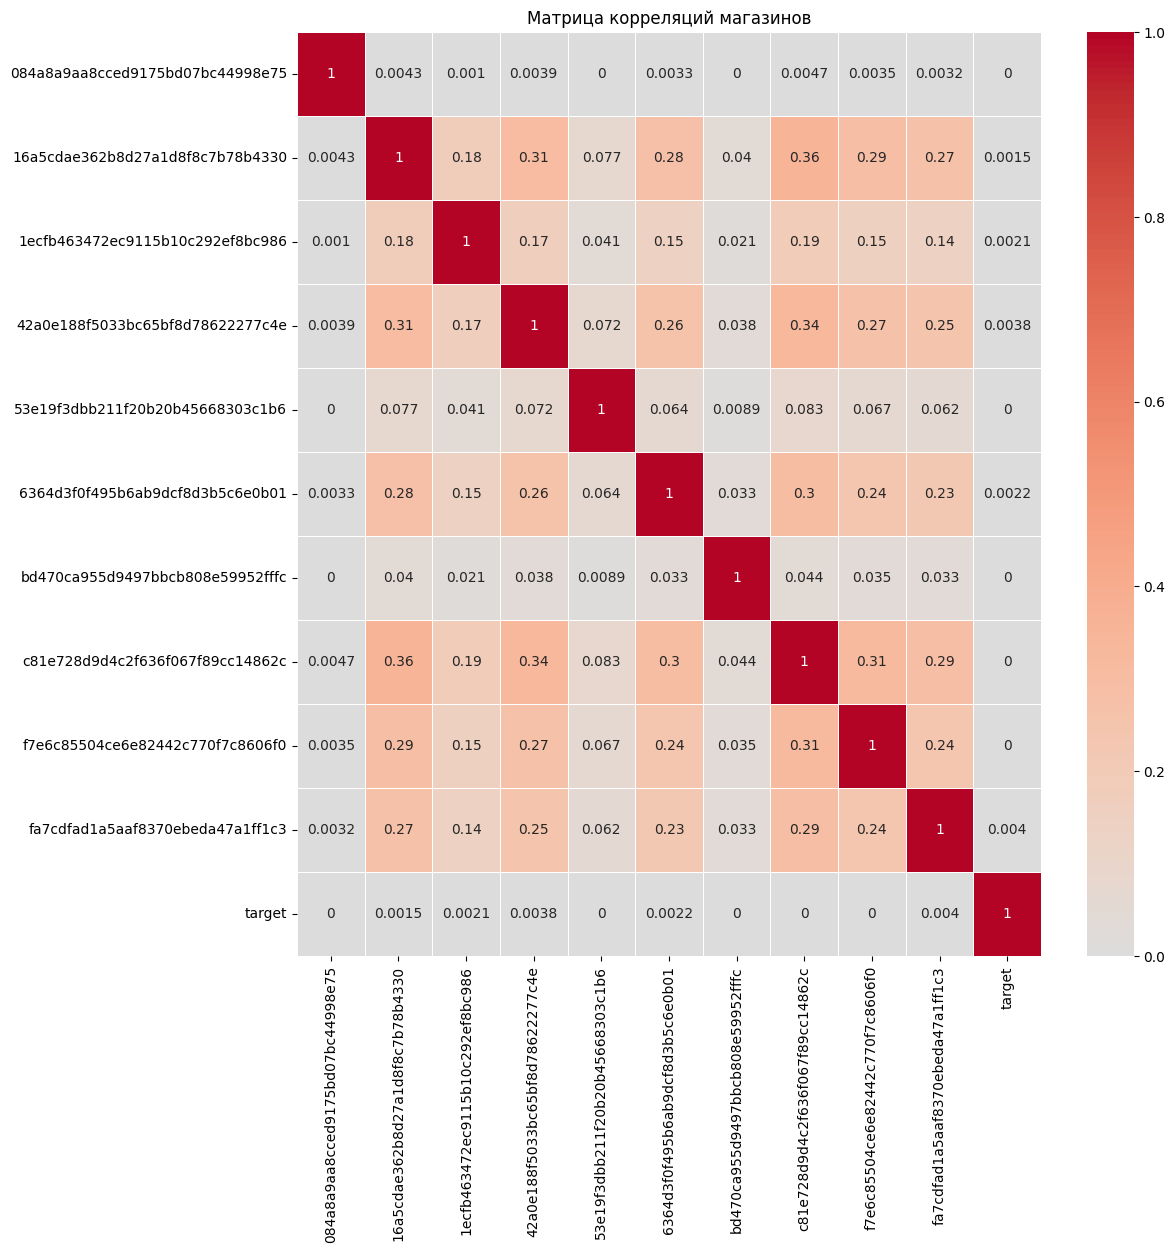

In [ ]:
int_list = ['target']
plt.figure(figsize=(12,12))
(sns.heatmap(full_data_shops
             .phik_matrix(interval_cols=int_list),
             annot=True,
             linewidth=.5,
             cmap='coolwarm',
             center=0)
 .set(title="Матрица корреляций магазинов"))
plt.show()

In [ ]:
full_data.st_type_loc_id.unique()

array(['2', '1', '3'], dtype=object)

In [ ]:
full_data.loc[full_data.st_type_loc_id=='3', 'st_id'].unique()

array(['53e19f3dbb211f20b20b45668303c1b6',
       'bd470ca955d9497bbcb808e59952fffc',
       '084a8a9aa8cced9175bd07bc44998e75'], dtype=object)

При считывании id магазина имеет смысл разделять на две группы, у которых будут разные модели предсказания.

### Ищем корреляцию между группами товаров

In [ ]:
full_data.pr_group_id.nunique()

9

In [ ]:
full_data.pr_cat_id.nunique()

43

In [ ]:
full_data.pr_subcat_id.nunique()

165

Выведем группы в отдельные признаки

In [ ]:
full_data_groups = full_data.pr_group_id
full_data_groups = pd.get_dummies(full_data_groups)

присоеденим таргет:

In [104]:
full_data_groups['target'] = full_data['pr_sales_in_units']
full_data_groups.head()

1ff1de774005f8da13f42943881c655f  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            32bb90e8976aab5298d5da10fe66f21d  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            3c59dc048e8850243be8079a5c74d079  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            6512bd43d9caa6e02c990b0a82652dca  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            98f13708210194c475687be6106a3b84  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            aab3238922bcc25a6f606eb525ffdc56  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            c20ad4d76fe97759aa27a0c99bff6710  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   

            c51ce410c124a10e0db5e4b97fc2af39  \
date                                           
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 0   
2022-08-01                                 1   
2022-08-01                                 0   

            c74d97b01eae257e44aa9d5bade97baf  target  
date                                                  
2022-08-01                                 1     7.0  
2022-08-01                                 1     1.0  
2022-08-01                                 1     1.0  
2022-08-01                                 0     1.0  
2022-08-01                                 1     1.0

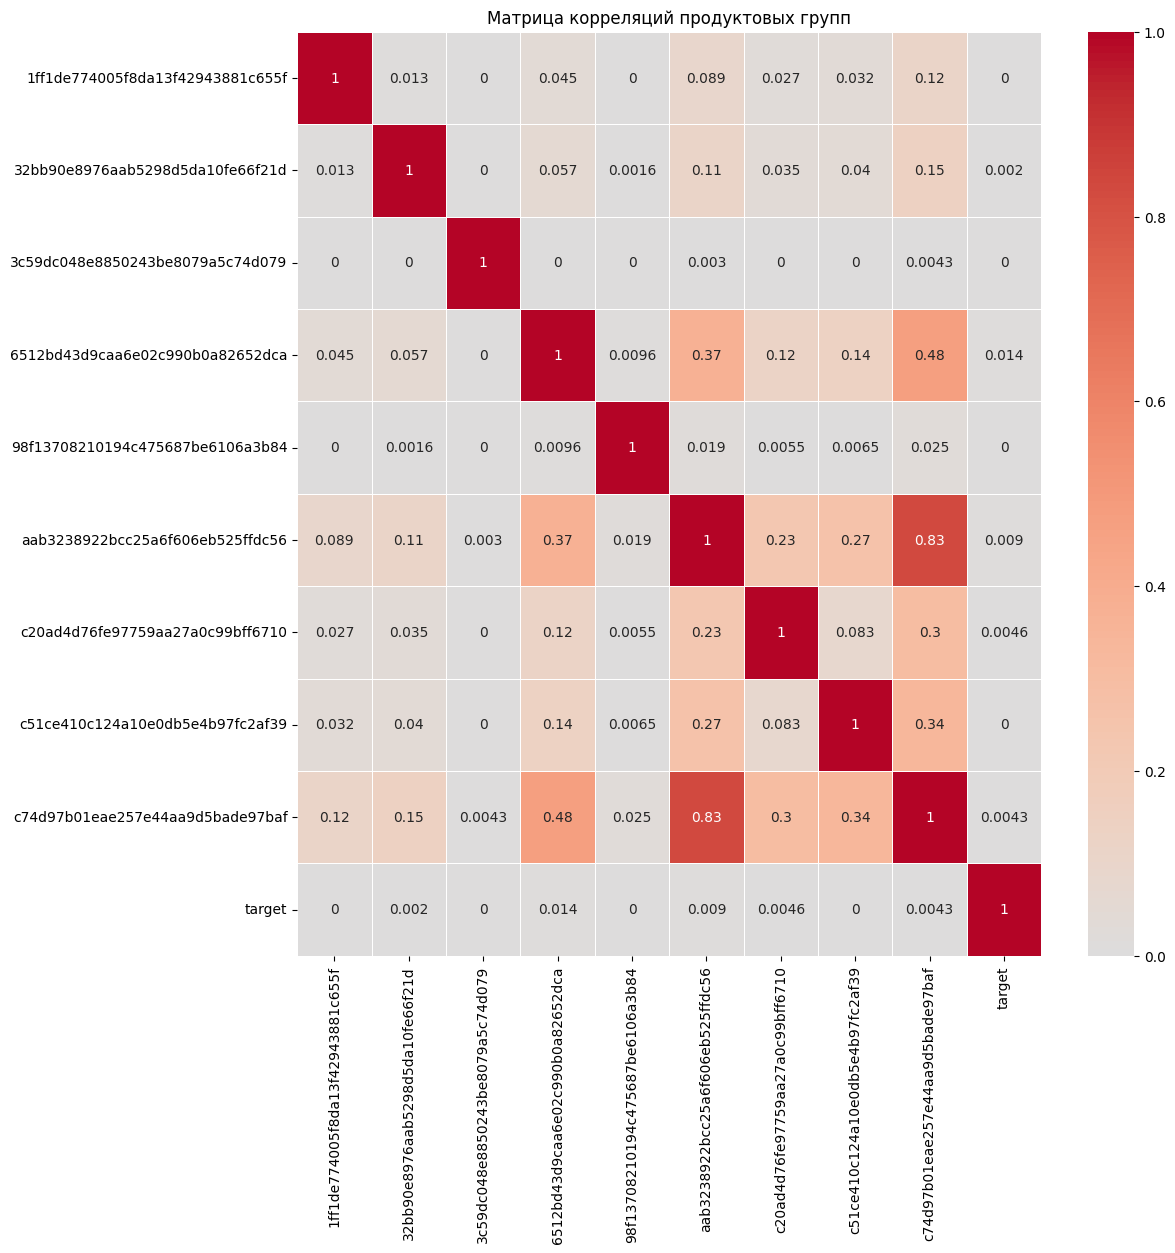

In [109]:
int_list = ['target']
plt.figure(figsize=(12,12))
(sns.heatmap(full_data_groups
             .phik_matrix(interval_cols=int_list),
             annot=True,
             linewidth=.5,
             cmap='coolwarm',
             center=0)
 .set(title="Матрица корреляций продуктовых групп"))
plt.show()

# Подготовка выборок и обучение моделей

In [110]:
full_data_origin = full_data.copy()

## Генерация фичей

Фирменные фичи:

In [111]:
def cross_seles_features(data):
    work_data = data.copy() # копируем данные

    # формируем промежуточную таблицу с информацией о продажах каждой группы товаров
    group_id = pd.DataFrame(data.groupby('pr_group_id')['pr_sku_id'].count()).reset_index()

    # формируем список значений продаж
    array_1 = list(group_id.pr_sku_id)

    # создаем квадратную матрицу размерностью группировочной таблицы
    matrix = np.zeros([len(group_id), len(group_id)])

    # заполняем матрицу значениями отношений группы в сумме двух групп
    for i in range(len(array_1)):
        for j in range(len(array_1)):
            if i != j:
                matrix[i][j] = (array_1[i]/(array_1[i] + array_1[j]))
            elif i == j:
                matrix[i][j] = 1

    # объединяем группировку и матрицу со значениями
    df_new = pd.concat([group_id, pd.DataFrame(matrix)], axis= 1)

    # переименование колонок для удобства работы, столбцы фичей начинаются с "f_"
    for i in range(2, len(df_new.columns)):
        df_new = df_new.rename(columns={i-2 : f'f_{df_new.loc[i-2, "pr_group_id"]}'})

    # создаем в рабочей таблице колонки со значениями из матрицы со значением 0
    work_data[[list(df_new.columns)[2:]]] = 0

    # заполняем финальную таблицу значениями из промежуточной таблицы
    for i in data.pr_group_id.unique():
        for j in range(2, len(df_new.columns)):
            work_data.loc[work_data['pr_group_id'] == i, df_new.columns[j]] = \
                float(df_new.loc[df_new['pr_group_id'] == i, df_new.columns[j]])


    return work_data

### Добавление выходных дней

In [112]:
def add_holidays(df,rus_holidays):
    rus_holi = rus_holidays.copy()
    rus_holi['date'] = pd.to_datetime(rus_holi['date'], format='%d.%m.%Y')
    df = df.merge(rus_holi[['date', 'holiday']], on='date')
    df = df.set_index('date')
    df['holiday'] = df['holiday'].astype(str)
    return df

### Добавление признаков по временным рядам


In [114]:
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

In [115]:
def make_features(data, max_lag, rolling_mean_size):
        data['day'] = data.index.day.astype(str)
        data['dayofweek'] = data.index.dayofweek.astype(str)
        data['month'] = data.index.month.astype(str)

    # Создаем лаги для продаж для каждой комбинации 'st_id', 'pr_sku_id' и 'pr_sales_type_id'
        for lag in range(15, max_lag + 1,7):
            data[f'lag_{lag}_pr_sales_in_units'] = data.groupby(
                ['st_id','pr_sku_id','pr_sales_type_id'])['pr_sales_in_units'].shift(lag)
        data['lag_16'] = data.groupby(['st_id', 'pr_sku_id', 'pr_sales_type_id'])['pr_sales_in_units'].shift(16)
        data['lag_23'] = data.groupby(['st_id', 'pr_sku_id', 'pr_sales_type_id'])['pr_sales_in_units'].shift(23)

        data['rolling_mean'] = data['pr_sales_in_units'].shift().rolling(rolling_mean_size).mean()
        return data

In [116]:
def roll_mean_features(data, windows):
    def add_noise(x):
        return x + np.random.normal(size=len(x))

    for window in windows:
        data['sales_roll_mean_' + str(window)] = data.groupby(
            ['st_id', 'pr_sku_id', 'pr_sales_type_id'])['pr_sales_in_units']. \
                                                          transform(
            lambda x: x.shift(15).rolling(window=window, min_periods=7, win_type="triang").mean())
        data['sales_roll_mean_' + str(window)] = data.groupby(
            ['st_id', 'pr_sku_id', 'pr_sales_type_id'])['sales_roll_mean_' + str(window)].transform(add_noise)
    return data

In [117]:
def clean_df(data):
    data = data.drop(['st_city_id',
                  'st_division_code',
                  'st_type_format_id',
                  'st_type_loc_id',
                  'st_type_size_id',
                  'pr_group_id',
                  'pr_cat_id',
                  'pr_subcat_id',
                  'pr_uom_id',
#                 'pr_sales_type_id'
                 ], axis=1)
    return data

In [118]:
def split_and_prophet(df,split_date):
# делим выборку
    train = df.loc[df.index < pd.to_datetime(split_date, format='%Y-%m-%d')]
    test = df.loc[df.index >= pd.to_datetime(split_date, format='%Y-%m-%d')]

# признаки prophet для обучающей выборки

# Prophet по штукам
    train_prophet_unit = train.copy()
    train_prophet_unit = train_prophet_unit.pr_sales_in_units.reset_index()
    train_prophet_unit = train_prophet_unit.rename(columns={'date': 'ds', 'pr_sales_in_units': 'y'})
    model_prophet_unit = Prophet()
    model_prophet_unit = model_prophet_unit.fit(train_prophet_unit)
    future_unit = model_prophet_unit.make_future_dataframe(periods=(len(test.index.unique())))
    forecast_unit = model_prophet_unit.predict(future_unit)
    prophet_data_unit = forecast_unit[['trend','yhat','weekly','ds']].set_index('ds', drop=True)

# Prophet по рублям
    train_prophet_rub = train.copy()
    train_prophet_rub = train_prophet_rub.pr_sales_in_rub.reset_index()
    train_prophet_rub = train_prophet_rub.rename(columns={'date': 'ds', 'pr_sales_in_rub': 'y'})
    model_prophet_rub = Prophet()
    model_prophet_rub = model_prophet_rub.fit(train_prophet_rub)
    future_rub = model_prophet_rub.make_future_dataframe(periods=(len(test.index.unique())))
    forecast_rub = model_prophet_rub.predict(future_rub)
    prophet_data_rub = forecast_rub[['trend','yhat','weekly','ds']].set_index('ds', drop=True)
    prophet_data_rub = prophet_data_rub.rename(columns={'trend':'trend_rub', 'yhat':'yhat_rub','weekly':'weekly_rub'})

# добавляем признаки от prophet
    train = pd.merge(train,prophet_data_unit, how='left', left_index=True, right_index=True)
    train = pd.merge(train,prophet_data_rub, how='left', left_index=True, right_index=True)
    feature_train = train.drop(['pr_sales_in_units','pr_sales_in_rub'], axis=1)
    target_train = train.pr_sales_in_units
# тестовая выборка
    test = pd.merge(test,prophet_data_unit, how='left', left_index=True, right_index=True)
    test = pd.merge(test,prophet_data_rub, how='left', left_index=True, right_index=True)
    features_test = test.drop(['pr_sales_in_units','pr_sales_in_rub'], axis=1)
    target_test = test.pr_sales_in_units
    return feature_train, target_train,features_test,target_test

In [119]:
def to_category(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] =  df[column].astype('category')
    return df

Собственный скорер:

In [120]:
#создадим метрику для использования в кросс-валидации
my_score = make_scorer(wape,
                       greater_is_better=False
                      )

### Обучение моделей для двух групп

In [125]:
# Данные по моделям
list_model           = []
list_wape_cross_vall = []
list_wape_test       = []

In [126]:
# Создадим пять подвыборок с помощью TimeSeriesSplit

folds = TimeSeriesSplit(n_splits = 10)

In [127]:
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, data, **transform_params):
        return self.func(data)

    def fit(self, X, y=None, **fit_params):
        return self

In [131]:
 drop_columns = ['st_city_id',
                'st_division_code',
                'st_type_format_id',
                'st_type_loc_id',
                'st_type_size_id',
                'pr_group_id',
                'pr_cat_id',
                'pr_subcat_id',
                'pr_uom_id',
                'month',
                'st_id',
                'pr_sku_id',
                'pr_sales_type_id',
                'holiday',
                'day',
                'dayofweek',
                'trend',
                'yhat',
                'weekly',
                'trend_rub',
                'yhat_rub',
                'weekly_rub'
                ]

### Проверка на адекватность

In [174]:
# pred_dummy = (target_test_gr_1.shift(fill_value=target_train_gr_1.mean()))
# wape_dummy_1 = wape(target_test_gr_1, pred_dummy)

# pred_dummy = (target_test_gr_2_t.shift(fill_value=target_train_gr_2_t.mean()))
# wape_dummy_2_TOP = wape(target_test_gr_2_t, pred_dummy)

# pred_dummy = (target_test_gr_2_b.shift(fill_value=target_train_gr_2_b.mean()))
# wape_dummy_2_BOT = wape(target_test_gr_2_b, pred_dummy)

# pred_dummy = (target_test_gr_4.shift(fill_value=target_train_gr_4.mean()))
# wape_dummy_4 = wape(target_test_gr_4, pred_dummy)

# pred_dummy = (target_test_fd.shift(fill_value=target_train_fd.mean()))
# wape_dummy_FULL_DATA = wape(target_test_fd, pred_dummy)

In [175]:
# Dummy_wape_mean = pd.DataFrame({'Группа_1':round(wape_dummy_1,4),
#                           'Группа_2_TOP':round(wape_dummy_2_TOP,4),
#                           'Группа_2_BOTTOM':round(wape_dummy_2_BOT,4),
#                           'Группа_4':round(wape_dummy_4,4),
#                           'Группа_FULL_DATA':round(wape_dummy_FULL_DATA,4)},index=['WAPE_Dummy_MEAN'])
# Dummy_wape_mean.T

## Разделение по рейтингу продаж товаров

Мы проанализировали обучаемость моделей на полном датасете и на датасете без данных о промо-товарах и, как мы и ожидали, модели обучились лучше на данных без промо. Промо вызывают большие и зачастую непредсказуемые всплески продаж, которые могут путать модели и мешать обучению.

В связи с этим, мы посчитали наиболее эффективным подходом обучить отдельную модель для прогноза спроса на товары без промо. Что касается спроса на товары с промо, рекомендуем использовать дополнительные данные, такие как планы промоакций магазинов, локальные праздники и т.д. - это поможет сделать прогноз более качественным.

In [217]:
full_data_origin = full_data_origin.loc[full_data_origin.pr_sales_type_id == '0']

In [218]:
sku_number = []
sales_percentage = []
# цикл по ТОП-i товаров
for i in range(0,510,10):
    percent = (full_data_origin
                .groupby('pr_sku_id')
                .agg({'pr_sales_in_units':'sum'})
                .sort_values(by='pr_sales_in_units', ascending=False)['pr_sales_in_units']
                .head(i)
                .sum()
                /full_data_origin.groupby('pr_sku_id')
                .agg({'pr_sales_in_units':'sum'})
                .sort_values(by='pr_sales_in_units', ascending=False)['pr_sales_in_units']
                .sum())*100
# сохраняем результаты в списки
    sku_number.append(i)
    sales_percentage.append(round(percent,2))
# датафрейм с результатаыми
sales_info = pd.DataFrame({'sku_number':sku_number,
                           'sales_percentage':sales_percentage})

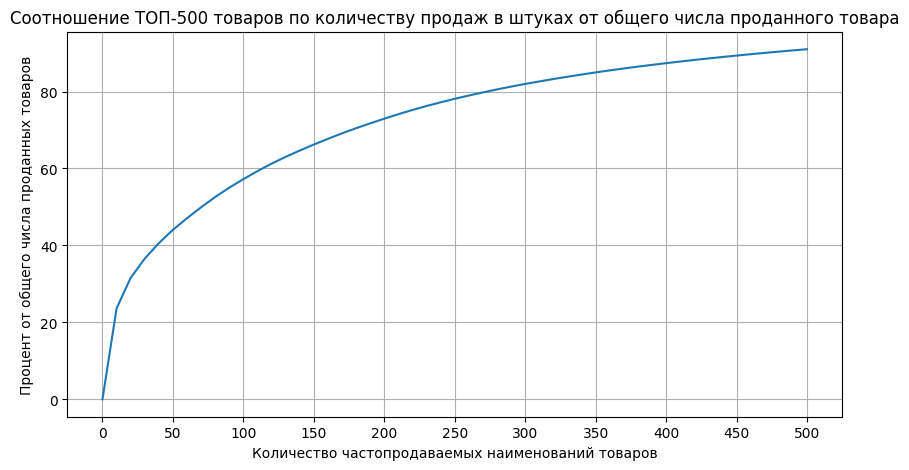

In [219]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=sales_info,
            x='sku_number',
            y='sales_percentage',
            ).set_xticks(range(0,550,50))
plt.grid(True)
plt.title('Соотношение ТОП-500 товаров по количеству продаж в штуках от общего числа проданного товара')
plt.xlabel('Количество частопродаваемых наименований товаров')
plt.ylabel('Процент от общего числа проданных товаров')
plt.show()

In [220]:
def df_divide_rate(df, top_number):
    # ТОП-товары
    top_sku = (df.groupby('pr_sku_id')
               .agg({'pr_sales_in_units':'sum'})
               .sort_values(by='pr_sales_in_units', ascending=False)
               .head(top_number)
               .index
               .tolist())
    # Группа 1
    group_1_rate = df.loc[df['pr_sku_id'].isin(top_sku)]

    # Группа 2
    group_2_rate = df.loc[~df['pr_sku_id'].isin(top_sku)]


    return group_1_rate, group_2_rate

In [221]:
group_1_rate, group_2_rate = df_divide_rate(full_data_origin,50)

In [222]:
# Добавляем выходные дни
group_1_rate = add_holidays(group_1_rate, holidays)
group_2_rate = add_holidays(group_2_rate, holidays)

In [223]:
# оптимальный max_lag определили как 14 дней
# rolling_mean_size = 14
group_1_rate = make_features(group_1_rate, 57, 15)
group_2_rate = make_features(group_2_rate, 57, 15)

In [224]:
group_1 = roll_mean_features(group_1_rate, [15, 16, 17, 18, 30])
group_2 = roll_mean_features(group_2_rate, [15, 16, 17, 18, 30])

In [225]:
group_1_rate = group_1_rate.dropna()
group_2_rate = group_2_rate.dropna()

In [226]:
# Добавляем Prophet предсказания и делим на выборки
split_date = '2023-07-05'

feature_train_gr_1_rate, target_train_gr_1_rate, features_test_gr_1_rate, target_test_gr_1_rate = split_and_prophet(group_1_rate,split_date)
feature_train_gr_2_rate, target_train_gr_2_rate, features_test_gr_2_rate, target_test_gr_2_rate = split_and_prophet(group_2_rate,split_date)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2z1yx1mb/16lwf70d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2z1yx1mb/cikzevyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80900', 'data', 'file=/tmp/tmp2z1yx1mb/16lwf70d.json', 'init=/tmp/tmp2z1yx1mb/cikzevyf.json', 'output', 'file=/tmp/tmp2z1yx1mb/prophet_models6pxyhy6/prophet_model-20231010070645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:06:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:07:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

In [227]:
# Данные по моделям
list_model_rate           = []
list_wape_cross_vall_rate = []
list_wape_test_rate       = []

### Модель для группы 1

**LGBMRegressor**

{'n_estimators': 650, 'reg_alpha': 1.6697426770977588, 'reg_lambda': 0.0957642066347741, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 814, 'min_child_samples': 119, 'min_data_per_groups': 25}

In [228]:
%%time
# Создаём LGBMRegressor GROUP_1

# Гиперпараметры для вариации
param_grid = {
              #'regressor__max_depth': range(2,9,1),
              'regressor__max_depth': [2,8],
              #'regressor__learning_rate':np.arange(0.02, 0.08, 0.01),
              #'regressor__n_estimators':range(100,500,100)
             }

# Создаём LGBMRegressor
model = Pipeline(steps =[
    ('features', DataframeFunctionTransformer(cross_seles_features)),
    ('cleaner', DataframeFunctionTransformer(clean_df)),
    ('to_cat',DataframeFunctionTransformer(to_category)),
    ('regressor', LGBMRegressor(random_state=13,
                                learning_rate=0.04,
                                n_estimators=300))])

# Задаём вариатор для поиска оптимальных гиперпараметров
grid_search = GridSearchCV(model,
                           param_grid,
                           cv=folds,
                           scoring=my_score,
                           n_jobs=-1)

# Обучим GridSearch на ТОР-5 признаков
grid_search.fit(feature_train_gr_1_rate, target_train_gr_1_rate)

# Выведем результат
print(grid_search.best_params_, grid_search.best_score_)

# Сохраним полученную модель
model_lgbmr_1_rate = deepcopy(grid_search.best_estimator_)

# Сохраним время обучения и предсказания
fit_time = grid_search.cv_results_['mean_fit_time'].mean()
score_time = grid_search.cv_results_['mean_score_time'].mean()

print('LGBMRegressor GROUP_1 "WAPE":',round(-grid_search.best_score_,4))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4903
[LightGBM] [Info] Number of data points in the train set: 54571, number of used features: 31
[LightGBM] [Info] Start training from score 14.739477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

Проверка на тесте:

In [229]:
prediction = model_lgbmr_1_rate.predict(features_test_gr_1_rate)
prediction_1_rate = []
for i in range(len(prediction)):
    prediction_1_rate.append(int(prediction[i]))
pred_test_1_rate = wape(target_test_gr_1_rate,prediction_1_rate)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [230]:
features_test_gr_1_rate.shape

(2909, 37)

In [231]:
# добавим данные в аккумулирующую таблицу

list_model_rate.append('Group_1_LGBMRegressor')
list_wape_cross_vall_rate.append(round(-grid_search.best_score_,4))
list_wape_test_rate.append(round(pred_test_1_rate,4))

**LinearRegression**

In [232]:
# feature_train_gr_1_rate_lr = feature_train_gr_1_rate.drop(drop_columns, axis=1)
# features_test_gr_1_rate_lr = features_test_gr_1_rate.drop(drop_columns, axis=1)

In [233]:
# # Оценим качество модели

# scores = cross_val_score(model_lr,
#                          feature_train_gr_1_rate_lr,
#                          target_train_gr_1_rate,
#                          scoring=my_score,
#                          cv=folds,
#                          n_jobs=-1)

# # Обучение модели

# model_lr_gr_1_rate = model_lr.fit(feature_train_gr_1_rate_lr,target_train_gr_1_rate)

# print('LinearRegression:',round(-scores.mean(),4))

In [234]:
# # Проверка на тестовой выборке

# prediction = model_lr_gr_1_rate.predict(features_test_gr_1_rate_lr)
# prediction_lr_1_rate = []
# for i in range(len(prediction)):
#     prediction_lr_1_rate.append(int(prediction[i]))
# pred_test_lr_1_rate = wape(target_test_gr_1_rate,prediction_lr_1_rate)

In [235]:
# list_model_rate.append('Group_1_LinearRegression')
# list_wape_cross_vall_rate.append(round(-scores.mean(),4))
# list_wape_test_rate.append(round(pred_test_lr_1_rate,4))

### Модель для группы 2

In [236]:
%%time
# Создаём LGBMRegressor GROUP_2

# Гиперпараметры для вариации
param_grid = {
              #'regressor__max_depth': range(2,9,1),
              'regressor__max_depth': [2,8],
              #'regressor__learning_rate':np.arange(0.02, 0.08, 0.01),
              #'regressor__n_estimators':range(100,500,100)
             }

# Создаём LGBMRegressor
model = Pipeline(steps =[
    #('features', DataframeFunctionTransformer(cross_seles_features)),
    ('cleaner', DataframeFunctionTransformer(clean_df)),
    ('to_cat',DataframeFunctionTransformer(to_category)),
    ('regressor', LGBMRegressor(random_state=13,
                                learning_rate=0.06,
                                n_estimators=400))])

# Задаём вариатор для поиска оптимальных гиперпараметров
grid_search = GridSearchCV(model,
                           param_grid,
                           cv=folds,
                           scoring=my_score,
                           n_jobs=-1)

# Обучим GridSearch на ТОР-5 признаков
grid_search.fit(feature_train_gr_2_rate, target_train_gr_2_rate)

# Выведем результат
print(grid_search.best_params_, grid_search.best_score_)

# Сохраним полученную модель
model_lgbmr_2_rate = deepcopy(grid_search.best_estimator_)

# Сохраним время обучения и предсказания
fit_time = grid_search.cv_results_['mean_fit_time'].mean()
score_time = grid_search.cv_results_['mean_score_time'].mean()

print('LGBMRegressor GROUP_2 "WAPE":',round(-grid_search.best_score_,4))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4474
[LightGBM] [Info] Number of data points in the train set: 216556, number of used features: 27
[LightGBM] [Info] Start training from score 3.537856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

Проверка на тесте:

In [237]:
prediction = model_lgbmr_2_rate.predict(features_test_gr_2_rate)
prediction_2_rate = []
for i in range(len(prediction)):
    prediction_2_rate.append(int(prediction[i]))
pred_test_2_rate = wape(target_test_gr_2_rate,prediction_2_rate)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [238]:
# добавим данные в аккумулирующую таблицу

list_model_rate.append('Group_2_LGBMRegressor')
list_wape_cross_vall_rate.append(round(-grid_search.best_score_,4))
list_wape_test_rate.append(round(pred_test_2_rate,4))

**LinearRegression**

In [239]:
# feature_train_gr_2_rate_lr = feature_train_gr_2_rate.drop(drop_columns, axis=1)
# features_test_gr_2_rate_lr = features_test_gr_2_rate.drop(drop_columns, axis=1)

In [240]:
# # Оценим качество модели

# scores = cross_val_score(model_lr,
#                          feature_train_gr_2_rate_lr,
#                          target_train_gr_2_rate,
#                          scoring=my_score,
#                          cv=folds,
#                          n_jobs=-1)

# # Обучение модели

# model_lr_gr_2_rate = model_lr.fit(feature_train_gr_2_rate_lr,target_train_gr_2_rate)

# print('LinearRegression:',round(-scores.mean(),4))

In [241]:
# # Проверка на тестовой выборке

# prediction = model_lr_gr_2_rate.predict(features_test_gr_2_rate_lr)
# prediction_lr_2_rate = []
# for i in range(len(prediction)):
#     prediction_lr_2_rate.append(int(prediction[i]))
# pred_test_lr_2_rate = wape(target_test_gr_2_rate,prediction_lr_2_rate)

In [242]:
# list_model_rate.append('Group_2_LinearRegression')
# list_wape_cross_vall_rate.append(round(-scores.mean(),4))
# list_wape_test_rate.append(round(pred_test_lr_2_rate,4))

In [243]:
models_score_rate = (pd.DataFrame(
    {'Группа':list_model_rate,
     'WAPE cross_vall score':list_wape_cross_vall_rate,
     'WAPE test score': list_wape_test_rate})
                .set_index('Группа'))

models_score_rate

WAPE cross_vall score  WAPE test score
Группа                                                       
Group_1_LGBMRegressor                 0.4106           0.3824
Group_2_LGBMRegressor                 0.4723           0.4538

Склееный вариант:

In [244]:
full_pred_rate = np.concatenate((prediction_1_rate,prediction_2_rate), axis=0)

In [245]:
full_parts_rate = pd.concat([target_test_gr_1_rate, target_test_gr_2_rate])

In [246]:
full_parts_wape_rate = wape(full_parts_rate,full_pred_rate)

In [247]:
round(full_parts_wape_rate,4)

0.421

In [248]:
len(target_test_gr_2_rate)

14763

а теперь с LR:

In [249]:
# full_pred_lr_rate = np.concatenate((prediction_lr_1_rate,prediction_lr_2_rate), axis=0)

In [250]:
# full_parts_wape_lr_rate = wape(full_parts_rate,full_pred_lr_rate)

In [251]:
# round(full_parts_wape_lr_rate,4)

**Важность признаков:**

Для группы_1:

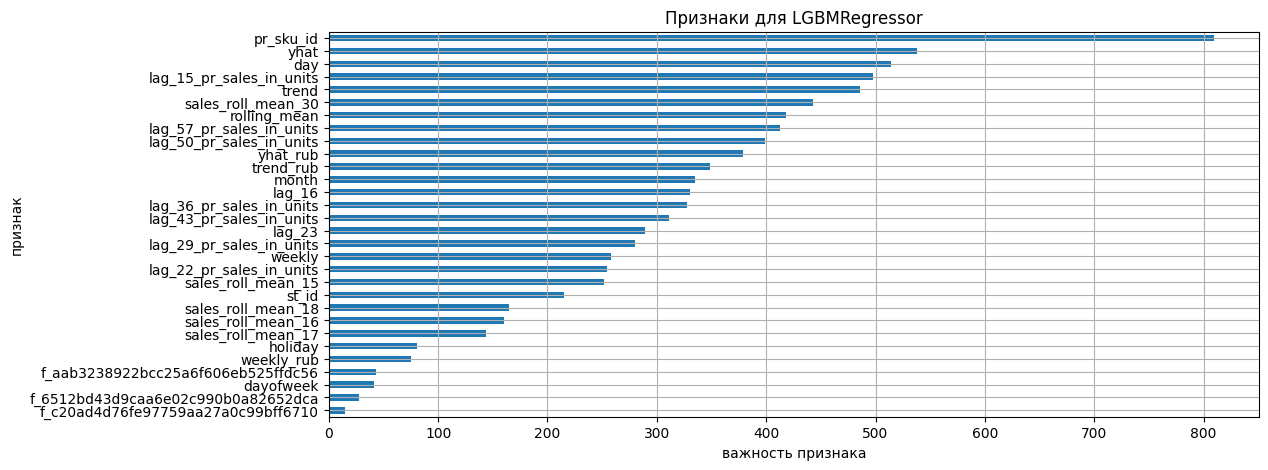

In [252]:
# сохраним feature_importances в датафрейм
imp_lgbmr_1 = pd.DataFrame(model_lgbmr_1_rate['regressor']
                      .feature_importances_,
                      index=model_lgbmr_1_rate['regressor'].feature_name_,
                      columns=['importances'])

# Визуализируем результат
imp_lgbmr_1.sort_values('importances').tail(30).plot(
    kind='barh',
    figsize=(12, 5),
    grid=True, legend=False)

plt.title('Признаки для LGBMRegressor')
plt.xlabel('важность признака')
plt.ylabel('признак')
plt.show()

Для группы_2:

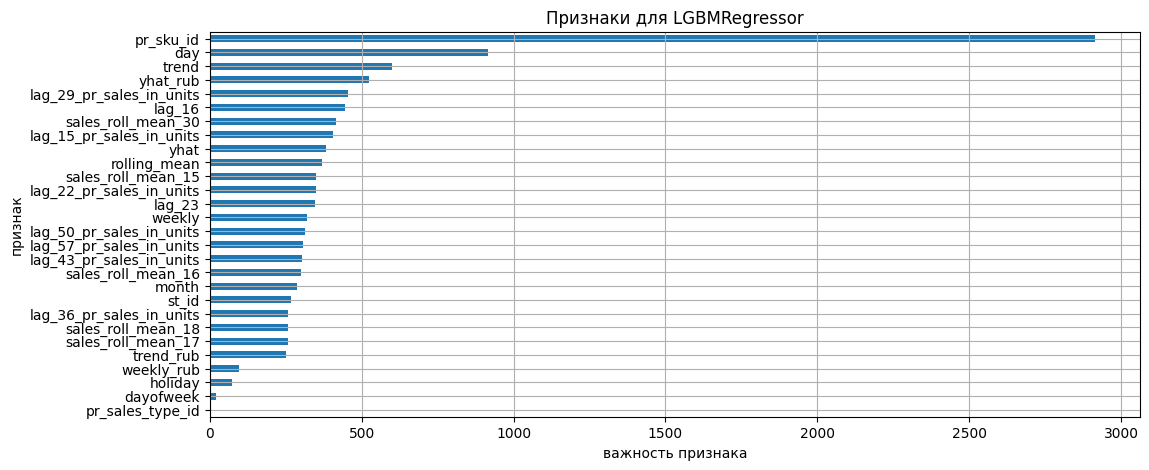

In [253]:
# сохраним feature_importances в датафрейм
imp_lgbmr_2 = pd.DataFrame(model_lgbmr_2_rate['regressor']
                      .feature_importances_,
                      index=model_lgbmr_2_rate['regressor'].feature_name_,
                      columns=['importances'])

# Визуализируем результат
imp_lgbmr_2.sort_values('importances').tail(30).plot(
    kind='barh',
    figsize=(12, 5),
    grid=True, legend=False)

plt.title('Признаки для LGBMRegressor')
plt.xlabel('важность признака')
plt.ylabel('признак')
plt.show()

##Бустим результат с помощью гибридной модели

Определим класс HybridModel, который представляет собой комбинированную модель, объединяющую две разные модели (model_1 и model_2 - сначала используем первую модель (model_1) для предсказания таргета, а затем вторую модель (model_2) для предсказания остатков (разницы между истинными значениями и предсказаниями первой модели). Таким образом, результаты двух моделей объединяются, чтобы улучшить точность прогнозов.

In [254]:
class HybridModel:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

def fit(self, X_1, X_2, y):
    # Обучаем первую модель
    self.model_1.fit(X_1, y)

    # Делаем предсказания
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    # Считаем остатки
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze()
# Обучаем вторую модель на остатках
    self.model_2.fit(X_2, y_resid)

    # Сохраняем данные
    self.y_columns = y.columns

    self.y_fit = y_fit
    self.y_resid = y_resid


def predict(self, X_1, X_2):
    # Предсказываем первой моделью
    y_pred_1 = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )

    # Предсказываем второй моделью остатки
    y_pred_2 = pd.DataFrame(
        self.model_2.predict(X_2),
        index=X_2.index, columns=self.y_columns,
    )

    # Добавляем предсказания модели 2 к предсказаниям модели 1
    y_pred = y_pred_1 + y_pred_2

    return y_pred


HybridModel.fit = fit
HybridModel.predict = predict

In [255]:
catboost_features = ['st_id', 'pr_sku_id', 'pr_sales_type_id']

In [256]:
from catboost import CatBoostRegressor

catboost_model = CatBoostRegressor(cat_features=catboost_features,
                                   #colsample_bylevel=0.09061531268899958,
                                   #depth=8,
                                   #boosting_type='Plain',
                                   #bootstrap_type='Bayesian',
                                   #n_estimators=500,
                                   #bagging_temperature=8.372060605048572,
                                   verbose = 300)

In [257]:
catboost_pipe = Pipeline(steps =[
    #('features', DataframeFunctionTransformer(cross_seles_features)),
    ('cleaner', DataframeFunctionTransformer(clean_df)),
    #('to_cat',DataframeFunctionTransformer(to_category)),
    ('regressor', CatBoostRegressor(cat_features=catboost_features,
                                verbose = 300))])

In [258]:
lgbm_pipe = Pipeline(steps =[
    #('features', DataframeFunctionTransformer(cross_seles_features)),
    ('cleaner', DataframeFunctionTransformer(clean_df)),
    ('to_cat',DataframeFunctionTransformer(to_category)),
    ('regressor', LGBMRegressor(random_state=13, n_estimators=800,
                              learning_rate= 0.014,
                                max_depth=8))])

In [259]:
hybrid_model_gr_1 = HybridModel(
    model_1= lgbm_pipe,
    model_2=catboost_pipe,
)

In [260]:
y_train_gr_1_rate = pd.DataFrame({'pr_sales_in_units': target_train_gr_1_rate.values})
y_train_gr_1_rate.index = target_train_gr_1_rate.index

In [261]:
hybrid_model_gr_1.fit(feature_train_gr_1_rate, feature_train_gr_1_rate, y_train_gr_1_rate)

y_pred_hybrid_1 = hybrid_model_gr_1.predict(features_test_gr_1_rate, features_test_gr_1_rate)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4883
[LightGBM] [Info] Number of data points in the train set: 54571, number of used features: 27
[LightGBM] [Info] Start training from score 14.739477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

In [262]:
wape_hybrid_1 = wape(target_test_gr_1_rate, y_pred_hybrid_1['pr_sales_in_units'].astype(int))
wape_hybrid_1

0.38456619497504024

### Линейная регрессия

In [263]:
# Определение Pipeline для Линейной регрессии

cat_transformer = Pipeline(steps=[
    ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, catboost_features),
    ])

linear_pipe = Pipeline(steps=[('cleaner', DataframeFunctionTransformer(clean_df)),
                              ('preprocessor', preprocessor),
                              ('scaler', StandardScaler()),
                            ('model', LinearRegression())])

In [264]:
hybrid_model_gr_1_lin = HybridModel(
    model_1= linear_pipe,
    model_2=lgbm_pipe,
)

In [265]:
hybrid_model_gr_1_lin.fit(feature_train_gr_1_rate, feature_train_gr_1_rate, y_train_gr_1_rate)

y_pred_hybrid_1_lin = hybrid_model_gr_1_lin.predict(features_test_gr_1_rate, features_test_gr_1_rate)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4883
[LightGBM] [Info] Number of data points in the train set: 54571, number of used features: 27
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

In [266]:
wape_hybrid_1_lin = wape(target_test_gr_1_rate, y_pred_hybrid_1_lin['pr_sales_in_units'].astype(int))
wape_hybrid_1_lin

0.3802137051858575

In [267]:
y_test_gr_1_rate = pd.DataFrame({'pr_sales_in_units': target_test_gr_1_rate.values})
y_test_gr_1_rate.index = target_test_gr_1_rate.index

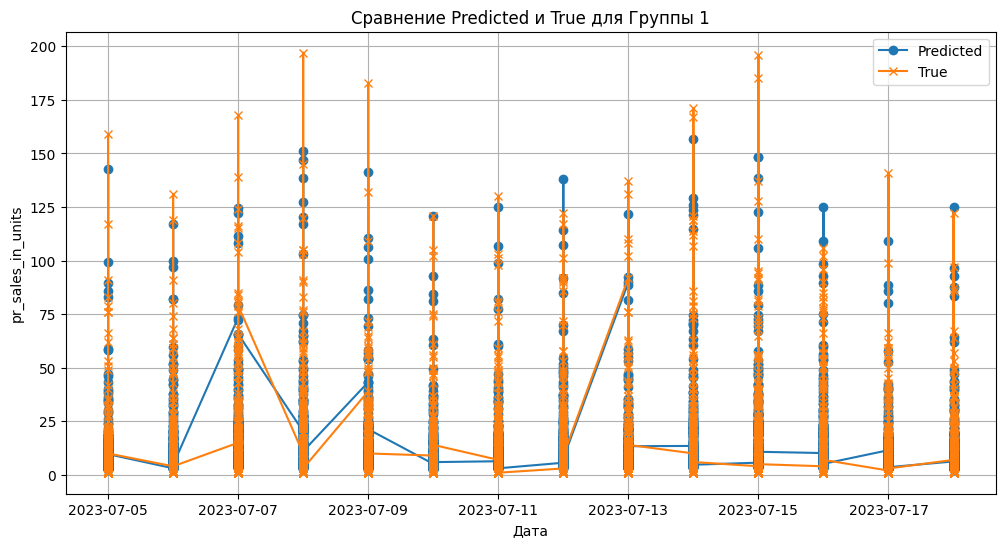

In [268]:
plt.figure(figsize=(12, 6))

plt.plot(y_pred_hybrid_1_lin.index, y_pred_hybrid_1_lin['pr_sales_in_units'], label='Predicted', marker='o')
plt.plot(y_test_gr_1_rate.index, y_test_gr_1_rate['pr_sales_in_units'], label='True', marker='x')

plt.xlabel('Дата')
plt.ylabel('pr_sales_in_units')
plt.title('Сравнение Predicted и True для Группы 1')
plt.legend()

plt.grid(True)
plt.show()

### Для группы 2

In [269]:
y_train_gr_2_rate = pd.DataFrame({'pr_sales_in_units': target_train_gr_2_rate.values})
y_train_gr_2_rate.index = target_train_gr_2_rate.index

In [270]:
hybrid_model_gr_2_lin = HybridModel(
    model_1= linear_pipe,
    model_2=lgbm_pipe,
)

In [271]:
hybrid_model_gr_2_lin.fit(feature_train_gr_2_rate, feature_train_gr_2_rate, y_train_gr_2_rate)

y_pred_hybrid_2_lin = hybrid_model_gr_2_lin.predict(features_test_gr_2_rate, features_test_gr_2_rate)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4474
[LightGBM] [Info] Number of data points in the train set: 216556, number of used features: 27
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [272]:
wape_hybrid_2_lin = wape(target_test_gr_2_rate, y_pred_hybrid_2_lin['pr_sales_in_units'].astype(int))
wape_hybrid_2_lin

0.4444132312662406

In [273]:
y_test_gr_2_rate = pd.DataFrame({'pr_sales_in_units': target_test_gr_2_rate.values})
y_test_gr_2_rate.index = target_test_gr_2_rate.index

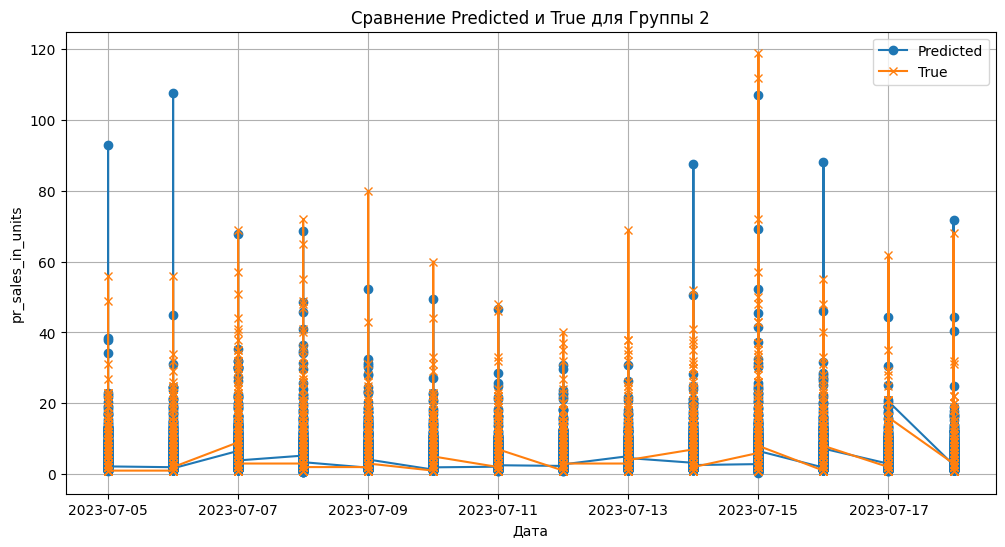

In [274]:
plt.figure(figsize=(12, 6))

plt.plot(y_pred_hybrid_2_lin.index, y_pred_hybrid_2_lin['pr_sales_in_units'], label='Predicted', marker='o')
plt.plot(y_test_gr_2_rate.index, y_test_gr_2_rate['pr_sales_in_units'], label='True', marker='x')

plt.xlabel('Дата')
plt.ylabel('pr_sales_in_units')
plt.title('Сравнение Predicted и True для Группы 2')
plt.legend()

plt.grid(True)
plt.show()

In [275]:
final_pred_rate = pd.concat((y_pred_hybrid_1_lin,y_pred_hybrid_2_lin), axis=0)

In [276]:
full_parts_rate = pd.concat([y_test_gr_1_rate, y_test_gr_2_rate])

In [277]:
final_wape_rate = wape(full_parts_rate,final_pred_rate)

In [278]:
round(final_wape_rate,4)

pr_sales_in_units    0.4223
dtype: float64

# FORECAST

In [281]:
def get_prophet(df):
# Prophet по штукам    train_prophet_unit = df.pr_sales_in_units.reset_index()
    train_prophet_unit = train_prophet_unit.rename(columns={'date': 'ds', 'pr_sales_in_units': 'y'})
    model_prophet_unit = Prophet()
    model_prophet_unit = model_prophet_unit.fit(train_prophet_unit)
# Prophet по рублям    train_prophet_rub = df.pr_sales_in_rub.reset_index()
    train_prophet_rub = train_prophet_rub.rename(columns={'date': 'ds', 'pr_sales_in_rub': 'y'})
    model_prophet_rub = Prophet()
    model_prophet_rub = model_prophet_rub.fit(train_prophet_rub)
    return model_prophet_unit, model_prophet_rub

In [284]:
# model_prophet_unit_1, model_prophet_rub_1 = get_prophet(group_1_rate)
# model_prophet_unit_2, model_prophet_rub_2 = get_prophet(group_2_rate)

In [285]:
def forecast(subm_data, train_data, holidays):
# 1. ФУНКЦИИ ПОДГОТОВКИ ФИЧЕЙ:
    # для добавления выходных
    def add_holidays(df,rus_holidays):
        rus_holidays['date'] = pd.to_datetime(rus_holidays['date'], format='%d.%m.%Y')
        df = df.merge(rus_holidays[['date', 'holiday']], on='date')
        df = df.set_index('date')
        df['holiday'] = df['holiday'].astype(str)
        return df

    # для разделения на группы
    def df_divide_rate(df):
    # ТОП-товары
        top_sku = (df.groupby('pr_sku_id')
                   .agg({'pr_sales_in_units':'sum'})
                   .sort_values(by='pr_sales_in_units', ascending=False)
                   .head(50)
                   .index
                   .tolist())
    # Группа 1
        group_1 = df.loc[df['pr_sku_id'].isin(top_sku)]

    # Группа 2
        group_2 = df.loc[~df['pr_sku_id'].isin(top_sku)]


        return group_1, group_2

    # для генерации лагов
    def make_features(data, max_lag, rolling_mean_size):
        data['day'] = data.index.day.astype(str)
        data['dayofweek'] = data.index.dayofweek.astype(str)
        data['month'] = data.index.month.astype(str)

    # Создаем лаги для продаж для каждой комбинации 'st_id', 'pr_sku_id' и 'pr_sales_type_id'
        for lag in range(15, max_lag + 1,7):
            data[f'lag_{lag}_pr_sales_in_units'] = data.groupby(
                ['st_id','pr_sku_id','pr_sales_type_id'])['pr_sales_in_units'].shift(lag)
        data['lag_16'] = data.groupby(['st_id', 'pr_sku_id', 'pr_sales_type_id'])['pr_sales_in_units'].shift(16)
        data['lag_23'] = data.groupby(['st_id', 'pr_sku_id', 'pr_sales_type_id'])['pr_sales_in_units'].shift(23)

        data['rolling_mean'] = data['pr_sales_in_units'].shift().rolling(rolling_mean_size).mean()
        return data

    def roll_mean_features(data, windows):
        def add_noise(x):
            return x + np.random.normal(size=len(x))

        for window in windows:
            data['sales_roll_mean_' + str(window)] = data.groupby(
                ['st_id', 'pr_sku_id', 'pr_sales_type_id'])['pr_sales_in_units']. \
                                                              transform(
                lambda x: x.shift(16).rolling(window=window, min_periods=7, win_type="triang").mean())
            data['sales_roll_mean_' + str(window)] = data.groupby(
                ['st_id', 'pr_sku_id', 'pr_sales_type_id'])['sales_roll_mean_' + str(window)].transform(add_noise)
        return data

    # для генерации фичей и деления выделения тестовой выборки
    def split_and_prophet(df,split_date, prophet_unit, prophet_rub):
    # делим выборку
        train = df.loc[df.index < pd.to_datetime(split_date, format='%Y-%m-%d')]
        test = df.loc[df.index >= pd.to_datetime(split_date, format='%Y-%m-%d')]

    # Prophet по штукам
        future_unit = prophet_unit.make_future_dataframe(periods=(len(test.index.unique())))
        forecast_unit = prophet_unit.predict(future_unit)
        prophet_data_unit = forecast_unit[['trend','yhat','weekly','ds']].set_index('ds', drop=True)

    # Prophet по рублям
        future_rub = prophet_rub.make_future_dataframe(periods=(len(test.index.unique())))
        forecast_rub = prophet_rub.predict(future_rub)
        prophet_data_rub = forecast_rub[['trend','yhat','weekly','ds']].set_index('ds', drop=True)
        prophet_data_rub = prophet_data_rub.rename(columns={'trend':'trend_rub', 'yhat':'yhat_rub','weekly':'weekly_rub'})

    # добавляем признаки от prophet
        test = pd.merge(test,prophet_data_unit, how='left', left_index=True, right_index=True)
        test = pd.merge(test,prophet_data_rub, how='left', left_index=True, right_index=True)
        features_test = test.drop(['pr_sales_in_units','pr_sales_in_rub'], axis=1)
        target_test = test.pr_sales_in_units
        return features_test,target_test


    # 2. ФУНКЦИИ ОСНОЫНЫЕ:
    # ОБЪЕДИНЕНИЕ SUBMISSION С ОБУЧАЮЩЕЙ ВЫБОРКОЙ:
    def get_sub_df(sub_df, train_df):
        train_df = train_df.loc[train_df.pr_sales_type_id == '0']
    # удаление товаров из submission, которых нет в train
        sub_df = sub_df.loc[sub_df.pr_sku_id.isin(train_df.pr_sku_id.unique().tolist())]
        sub_df_origin = sub_df.copy()
    # признаки для включения в submission
    # 'st_type_loc_id'
        loc_info = train_df.groupby('st_id').agg({'st_type_loc_id':'unique'}).reset_index()
        loc_info['st_type_loc_id'] = loc_info['st_type_loc_id'].apply(''.join)
    # 'pr_group_id'
        group_info = train_df.groupby('pr_sku_id')['pr_group_id'].unique().reset_index()
        group_info['pr_group_id'] = group_info['pr_group_id'].apply(''.join)
    # merge признаков к submission
        sub_df = pd.merge(sub_df,loc_info, how='left', on='st_id')
        sub_df = pd.merge(sub_df,group_info, how='left', on='pr_sku_id')
    # подготовка индексов перед merge
        sub_df['date'] = pd.to_datetime(sub_df['date'], format='%Y-%m-%d')
        sub_df = sub_df.set_index('date', drop=True)
        sub_df.sort_index(inplace=True)
    # сохраняем дату начала прогноза
        split_date = sub_df.index[0]
    # собираем в единый датафрейм
        train_sub_df = pd.concat([train_df,sub_df])
    # обработка пропусков
        train_sub_df = train_sub_df.drop('target', axis=1)
        train_sub_df['pr_sales_type_id'] = '0'
        train_sub_df.pr_sales_in_units = train_sub_df.pr_sales_in_units.fillna(0)
        train_sub_df.pr_sales_in_rub = train_sub_df.pr_sales_in_rub.fillna(0)
        train_sub_df = train_sub_df.fillna('drop_value')
        return train_sub_df, split_date, sub_df_origin

    # ПОДГОТОВКА ТЕСТОВОЙ ВЫБОРКИ РАЗБИТОЙ НА ГРУППЫ:
    def get_test_features(df, first_test_date):
    # добавляем флаг выходного дня
        df = add_holidays(df, holidays)
    # делим на группы
        gr_1_1,gr_2_top_2 = df_divide_rate(df)
    # добавляем лаги
        gr_1 = make_features(gr_1_1, 57, 15)
        gr_2_top = make_features(gr_2_top_2, 57, 15)
        gr_1 = roll_mean_features(gr_1, [15, 16, 17, 18, 30])
        gr_2_top = roll_mean_features(gr_2_top, [15, 16, 17, 18, 30])
    # заполняем пропуски от лагов
        gr_1 = gr_1.fillna(0)
        gr_2_top = gr_2_top.fillna(0)
    # добавляем признаки Prophet по штукам и рублям, выделяем test_features:
        features_test_gr_1, target_test_gr_1 = split_and_prophet(gr_1,first_test_date, model_prophet_unit_1, model_prophet_rub_1)
        features_test_gr_2_t, target_test_gr_2_t = split_and_prophet(gr_2_top,first_test_date, model_prophet_unit_2, model_prophet_rub_2)
        return features_test_gr_1, features_test_gr_2_t

    # ДЕЛАЕМ ПРЕДСКАЗАНИЕ
    def get_prediction(features_test_gr_1,
                       features_test_gr_2_t):
        prediction_1   = model_lgbmr_1_rate.predict(features_test_gr_1)
        prediction_2_t = model_lgbmr_2_rate.predict(features_test_gr_2_t)
        return prediction_1, prediction_2_t

    # СОБИРАЕМ ПРЕДСКАЗАНИЯ В SALES_SUBMISSION
    def predictions_to_submission(sub_data,
                              prediction_1,
                              prediction_2_t,
                              features_test_gr_1,
                              features_test_gr_2_t):
    # колонка для корректного merge
        sub_data['for_merge'] = sub_data['st_id']+sub_data['pr_sku_id']+sub_data['date']
    # удаляем нулевую колонку target
        sub_data = sub_data.drop('target', axis=1)
    # готовим группы к merge
    # добавляем полученные target
        features_test_gr_1['target'] = prediction_1
        features_test_gr_2_t['target'] = prediction_2_t
    # колонка для корректного merge
        features_test_gr_1['for_merge']   = (features_test_gr_1['st_id']
                                         +features_test_gr_1['pr_sku_id']
                                         +features_test_gr_1.index.astype(str))
        features_test_gr_2_t['for_merge'] = (features_test_gr_2_t['st_id']
                                         +features_test_gr_2_t['pr_sku_id']
                                         +features_test_gr_2_t.index.astype(str))

        full_set = pd.concat([features_test_gr_1,
                          features_test_gr_2_t])
        full_set = full_set[['for_merge','target']]

        full_set['target'] = full_set['target'].astype(int)

    # делаем submission
        sub_data = pd.merge(sub_data, full_set, how='left', on='for_merge')
    # удаляем вспомогательные данные
        sub_data = sub_data.drop('for_merge', axis=1)
        return sub_data

    # 3.ДЕЙСТВИЯ:
    # объединяем submission с трейн
    test_data, split, sales_sub = get_sub_df(subm_data, train_data)
    # готовим тестовые выборки
    ft_1, ft_2_t = get_test_features(test_data,split)
    # получаем предсказания
    pr_1, pr_2_t = get_prediction(ft_1, ft_2_t)
    # объединяем предсказания в submission датафрейм
    sales_submission_pred = predictions_to_submission(sales_sub,
                                                      pr_1,
                                                      pr_2_t,
                                                      ft_1,
                                                      ft_2_t)
    return sales_submission_pred

# Отчет

Перед нами стояла цель: разработать модель регрессии для прогноза спроса на 14 дней на товары собственного производства. Метрикой качества выступал WAPE, посчитанный на уровне товар, магазин, день.

В ходе работы были выполнены следующие шаги:

1. **Обзор и подготовка данных.**

- Были изучены данные, имеющиеся в распоряжении.
- Объединены таблицы, проведена предобработка: скорректированы отрицательные значения продаж, удалены данные с неактивными магазинами и аномальные данные, где отсутствует информация о количестве продаж, но есть информация о сумме продаж.

**Выводы о составе и качестве данных:**
Датасет состоит из множественных временных рядов, в каждом из которых уникальное сочетание "товар-магазин-наличие промо". Примечания по данным:

- у таргетного признака нет нормального распределения, присутствуют большие выбросы.
- по отдельным уникальным сочетаниям "товар-магазин-наличие промо" временной ряд не везде монотонен, есть прерывания.
- после уточнения у бизнеса выяснили, что данные pr_promo_sales_in_units и pr_promo_sales_in_rub дублируют информацию в pr_sales_in_units и pr_sales_in_rub, поэтому могут быть удалены.
- В файле submission отсутствует признак "наличие промо", уточнили у бизнеса, что в submission можно считать pr_sales_type_id равным 0.

2. **Исследовательский анализ данных.**

- Изучено взаимоотношение признаков в зависимости от магазинов, групп продуктов и т.д.
- Исследована корреляция признаков.
- Проведен анализ временных рядов.

**Выводы по проведенному исследованию:**

- Общий объем продаж в штуках относительно продаж по промоакциям составляет от 50 до 70%, при этом в рублях это составляет в среднем 50% от общего объема продаж.
- Рекордное число проданных товаров пришлось на период Пасхи (середина апреля) и на предновогодний период. Причем на Пасху продажи сопровождались промо, а после окончания апреля этот продукт и группа товаров больше не продавались (по-видимому, это были пасхальные куличи).
- Есть группы товаров с ярко выраженной сезонностью, тогда как у некоторых групп продажи более плавные и сезонность не так выражена.
- По магазинам распределение продаж неравномерное, есть явные лидеры по продажам и аутсайдеры.

Наблюдается яркий тренд в связке с государственными праздниками и временем года:

- резкое возрастание продаж перед новогодними праздниками, затем такое же резкое снижение,
- всплески в районе гендерных праздников,
- скачок продаж в апреле (Пасха) и на майские праздники, затем такой же небольшой скачок в июне (День России), высокие продажи летом, которые постепенно затухают осенью, и только в ноябре возникает небольшой всплеск (День народного единства).
- Доля остатков на протяжении года тоже меняется. Наибольший шум возникает всё так же в районе главных государственных праздников.
- В данных присутствует ярко выраженная недельная сезонность. По понедельникам самые низкие продажи, по пятницам - самые высокие.
- Если смотреть в разрезе отдельных групп товаров: только 4 из 9 групп имеют зависимость от праздников и времени года, у остальных эта зависимость не так выражена. Выбиваются две группы, по которым продажи были только в августе/сентябре.

**Выводы по корреляции признаков:**

- Ряд признаков сильно коррелирован между собой. В качестве решения проблемы мультиколлинеарности эти признаки были убраны из обучающей и тестовой выборки.

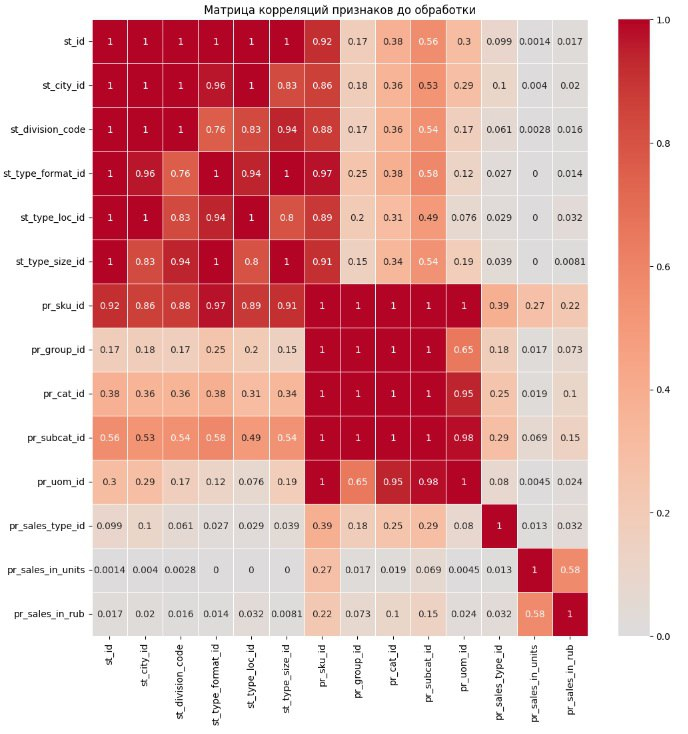

- Анализ матрицы корреляции магазинов позволяет разделить данные на две категории: коррелирующие между собой магазины и магазины, ни с кем не коррелирующие.
- Анализ матрицы корреляции групп товаров также позволяет разделить данные на две категории по тому же принципу: группы товаров с высокой мультиколлинеарностью, к которым отнисится 5 групп товаров, и группы товаров с низкой мультиколлинеарностью, к которым отнисится 4 группы товаров.


3. **Генерация новых признаков.**

Проверены различные гипотезы по созданию новых признаков, как по временным рядам, так и на основе данных о продажах, зависимостях от категорий и т.д.
В результате были выбраны для обучающей и тестовой выборки следующие признаки:

- Лаги и скользящие средние.
Наибольшую значимость при обучении модели продемонстрировали признаки по временным рядам: лаги и скользящие средние.
**! важное примечание:** поскольку мы предсказываем спрос на 14 дней вперед, нужно быть осторожнее при выборе размера лага. Мы не можем создавать лаги от 1 до 14, поскольку у нас нет данных о "pr_sales_in_units" из будущего. Поэтому важно создавать лаги начиная с 15-го.

В ходе проверки на автокорреляции по тесту Стьюдента мы выяснили, что есть смысл брать не более чем 57 лагов (8 недель). Но наиболее значим 15-й (ближайший из возможных день недели). В результате мы создали лаги от 15 до 57 с шагом в 7, а также дополнительно 16-й и 23-й лаги.

Для скользящих средних мы выбрали промежутки от 15 до 30. Чтобы повысить стабильность и обобщающую способность модели, а также сгладить выбросы и аномалии, мы добавили в скользящие средние случайный шум.

- Предсказания Prophet (future_dataframe) мы передали как дополнительные признаки для обучения моделей.

- Пометки о праздниках и выходных днях.

- Признаки по сопутствующим товарам.
Для генерации этих признаков была создана матрица размерностью групп товаров, для каждой группы товаров создано отношение искомая_группа / (искомая_группа + другая_группа) с целью показать вес группы в отношении этой группы с другой. К сожалению, в дальнейшем, после обучения моделей было выявлено минимальное влияние данных признаков на обучаемые модели.


4. **Разделение датасета на группы.**

Для получения наилучшего прогноза был проведен анализ возможности разделения датасета на кластеры четырьмя способами:
1.	На основе корреляции магазинов и корреляции товарных групп - на 4 группы.
2.	На основе корреляции только товарных групп - на 2 группы.
3.	На основе разделения на разное количество кластеров с помощью KMeans.
4.	На основе рейтинга продаж товаров в штуках - на 2 группы, с выделением в отдельную группу наиболее продаваемых товаров.
В случае каждого варианта разделения данных проводилась оценка моделей на кросс-валидации и тестовой выборке. В результате наиболее оптимальным показал себя подход №4.

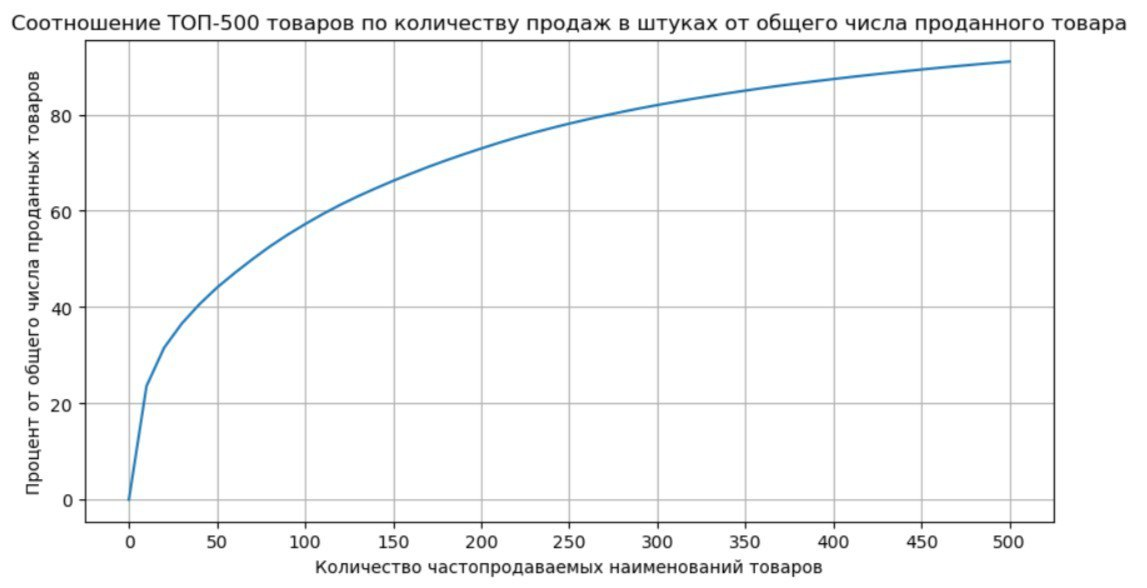


На графике приведено распределение соотношения ТОП-500 товаров по количеству продаж в штуках от общего числа проданного товара, на основании него было выделено в отдельную группу ТОП-50 товаров, которые составляют около 43% от общего количества проданного товара.


5. **Подбор и обучение моделей.**

Мы проверили различные гипотезы, связанные как с дополнительными признаками, так и с разбиением датасета на группы. При проверке применяли модели LGBM, CatBoost и Линейную регрессию, проверка осуществлялась на кросс-валидации с учетом специфики Time Series (то есть не перемешивая выборки и не подглядывая в будущее).

Кроме того, мы проанализировали обучаемость моделей на полном датасете и на датасете без данных о промо-товарах и, как мы и ожидали, модели обучились лучше на данных без промо. Промо вызывают большие и зачастую непредсказуемые всплески продаж, которые могут путать модели и мешать обучению.

В связи с этим, мы посчитали наиболее эффективным подходом обучить отдельную модель для прогноза спроса на товары без промо. Что касается спроса на товары с промо, рекомендуем использовать дополнительные данные, такие как планы промоакций магазинов, локальные праздники и т.д. - это поможет сделать прогноз более качественным.

**Описание решения:**

- Датасет был отобран по товарам без пометки "промо" и разделён на две группы (ТОП-50 и Остальные), в каждой из которых мы выделили обучающую и тестовую выборку так, чтобы тестовая выборка составляла 14 дней - то количество дней, на которое нам нужно делать предсказание.
- Каждая из обучающих выборок была насыщена признаками:
    - предсказание Prophet
    - лаги
    - скользящие средние
    - пометки о праздниках
- Выбранные модели: Hybrid Model = LGBMRegressor(random_state=13, n_estimators=800, learning_rate= 0.014, max_depth=8) + LinearRegression(). Мы написали класс для комбинированной модели HybridModel,  объединяющей две разные модели (сначала используем первую модель (model_1) для предсказания таргета, а затем вторую модель (model_2) для предсказания разницы между истинными значениями и предсказаниями первой модели). Таким образом, результаты двух моделей объединяются, чтобы улучшить точность прогнозов.
- Гиперпараметры подбирались с помощью Optuna и GridSearchCV (с учетом специфики TimeSeries).
- Для каждой из групп выбраны модели, которые продемонстрировали наименьший WAPE. В результате нам удалось достичь на тестовой выборке следующих результатов:
    - WAPE для группы 1 = 0.38
    - WAPE для группы 2 = 0.444

Важность признаков

Для первой группы

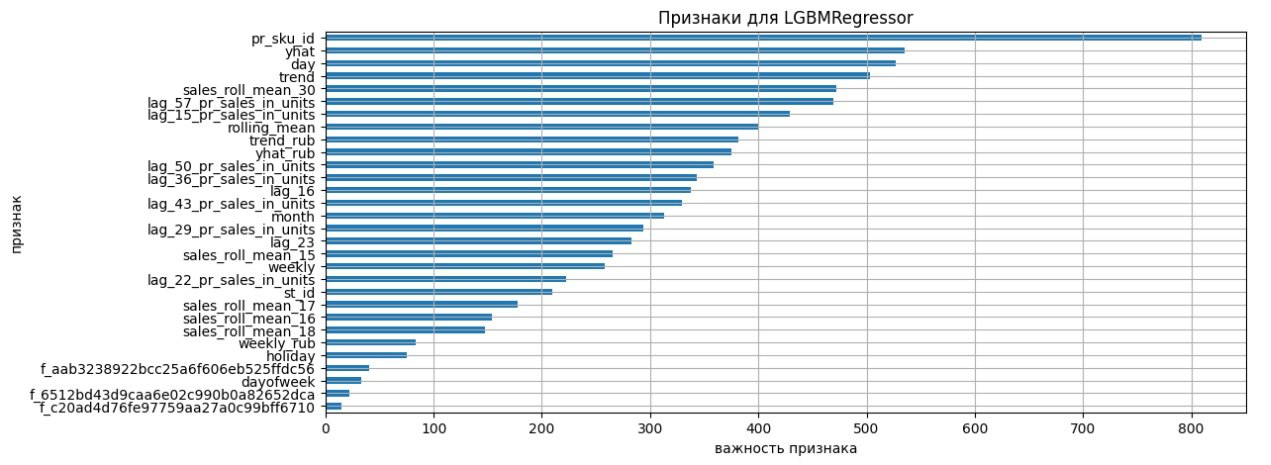

Для второй группы

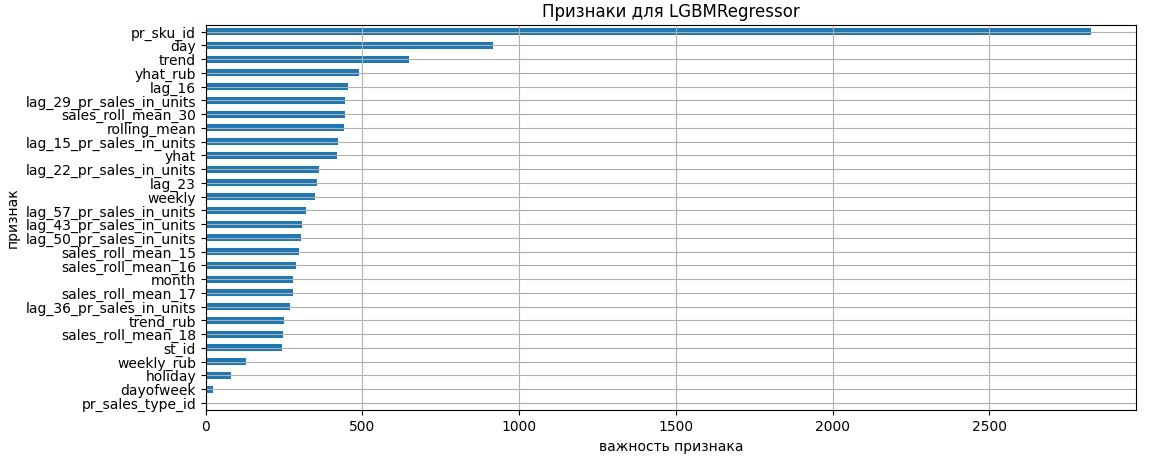


Графики True vs Pred

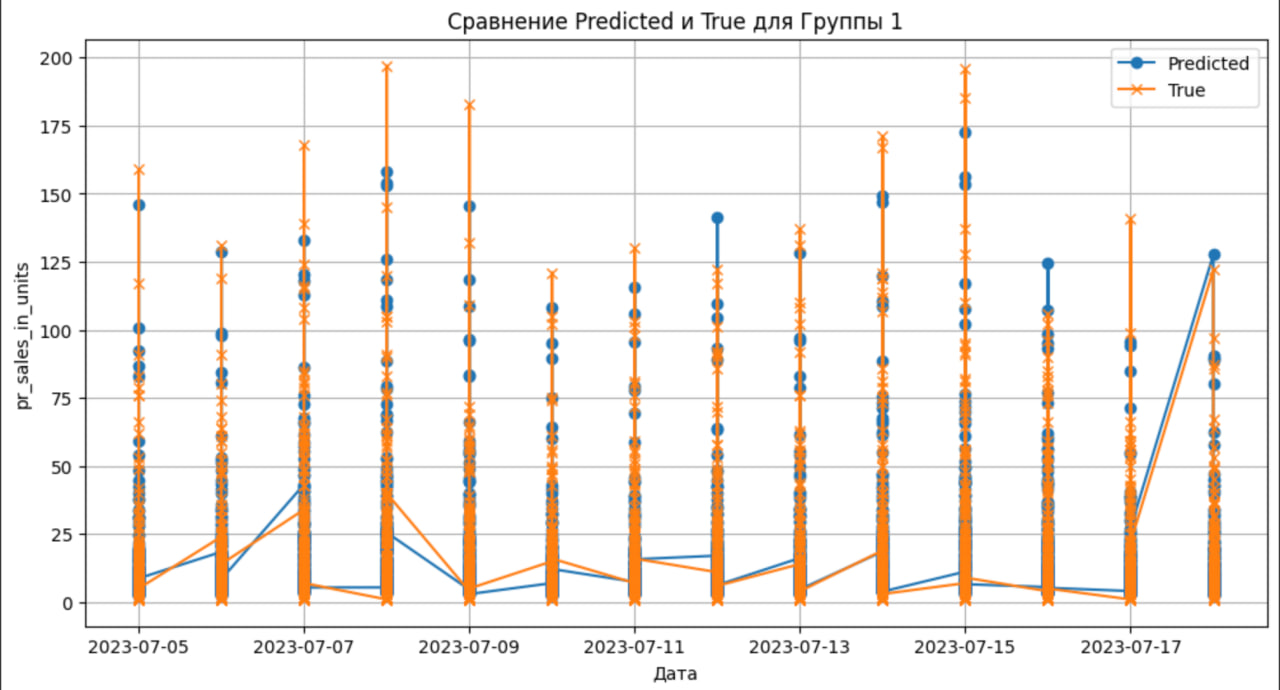

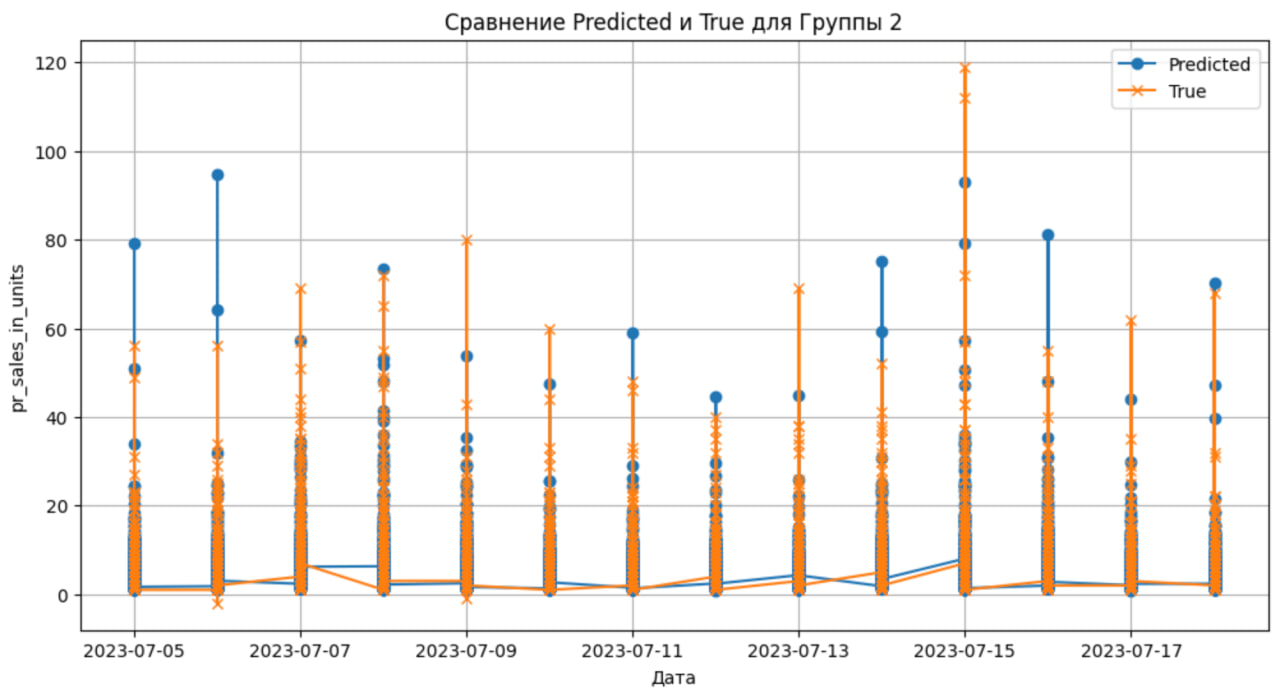